# **Table of Content**

* [Config param](#section-one)
* [Setup:: Tensorflow](#section-seventeen)
* [Setup:: Zoobot](#section-two)
    - [Subsection 1](#subsection-one)
    - [Subsection 2](#anything-you-like)
* [Import:: Library](#section-three)
* [Import:: Galaxy zoo 2 data](#section-four)
* [Import:: Galaxy Competition dataset](#section-five)
* [Import:: Physical properties](#section-twenty-two)
* [Load:: Model](#section-eighteen)
* [Load:: Data](#section-six)
    - [Image mapping](#subsection-one)
    - [Physical properties mapping](#subsection-two)
* [Class Mapping](#section-sixteen)
* [Weightage](#section-seven)
* [Prepare dataset](#section-eight)
* [Save Image](#section-eight2)
* [Upscale](#section-nine)
* [Load dataset](#section-ten)
* [Preprocess dataset](#section-eleven)
* [Visualization](#section-twelve)
* [Training](#section-thirteen)
* [Evaluation](#section-fourteen)
* [Report](#section-twenty)
* [Confusion Matrix](#section-twenty-one)
* [Analysis:: Physical Properties](#section-twenty-three)
* [Analysis:: Misclassification](#section-fifteen)
* [Analysis:: GradCam](#section-nineteen)

<a id="section-one"></a>
# **Config param**

# Changing parameters in paper

In [1]:
#-----------------
# upgrade & import
#----------------
bLoadModelEval = False # change this to switch between model training / evaluation

bImportModel = False # change to True if want to download model from google drive

project_name='zoobot_merge3_4'
model_path = '/kaggle/input/' + project_name + '/tensorflow2/default/1/finetune_minimal' # use model that has been upploaded to kaggle


#-----------------
# optional features
#-----------------
bGradCam = False # change to True if want to carry out XAI (gradcam++, smoothgrad) (training method is different from without XAI)


#-----------------
# data alternate
#-----------------
NUM_CLASS_INIT = 6 # original number of class

bClassSelect = False # use certain class to carry out training/evaluation

if (bClassSelect):
    class_sel_arr = [1,2] # select certain class

bClassMap = False # combine class
class_map = [0,1,2,3,3,4] # class combination

NUM_CLASS = 6 # number of class after select/combine


#-----------------
# training
#-----------------
bZoobot = True # use B0 / V2M 

# Fixed parameters in paper (only change for customization)

In [2]:
#-----------------
# upgrade & import
#----------------
bUpgradeTSF = True

bImportZoobot = True

bImportDataset = True


#-----------------
# optional features
#-----------------
bVisualize = True # visualize image sample in a table

bSaveImg = True # save all images

bMisclassify = True # evaluate misclassified and correct-classified images

bPhysicalProp = True # evaluate physical properties (stellar mass, SFR)


#-----------------
# dataset related (change this if want to use other dataset)
#-----------------
x_label=['1','2','3','4','5+','?']

file_format = 'jpeg'

csv_dir = '/kaggle/working/zoo2MainSpecz.csv'
csv_map = '/kaggle/working/gz2_filename_mapping.csv'
img_title = 'asset_id'
img_folder = '/kaggle/working/galaxy-zoo-2-images/images_gz2/images/'


#----------------------------
# dataset selection criteria (change this to use other selection criteria)
#----------------------------
bUseFilter = True

csv_data_filter=[
                't01_smooth_or_features_a02_features_or_disk',
                't02_edgeon_a05_no',
                't04_spiral_a08_spiral',
            ]

prob_filter=[
                0.43,
                0.715,
                0.619,
            ]

flag_filter=[
                0,
                0,
                0,
                #0,
            ]

csv_data_class=[
    't11_arms_number_a31_1',
    't11_arms_number_a32_2',
    't11_arms_number_a33_3',
    't11_arms_number_a34_4',
    't11_arms_number_a36_more_than_4',
    't11_arms_number_a37_cant_tell',   
]

flag_class=[
            1,
            1,
            1,
            1,
            1,
            1,
        ]

debiased_class=[
            0,
            0,
            0,
            0,
            0,
            0,
        ]    

max_no_class=[
                300,
                300,
                300,
                300,
                300,
                300,
]

val_num=[
                50,
                90,
                90,
                9,
                10,
                90,
]


#-----------------
# data alternate
#-----------------
initial_size = 424 # original image size

test_split = 0.3 # val-train ratio

bWeightage = False # assign weightage to class (reduce overfitting)


#-------------------
# data augmentation
#-------------------
crop_size = 224 # final size after cropping
resize_size = 224  # Zoobot, as pretrained, expects 224x224 images
dRotationFactor = 0.5 # rotation factor
dZoomFactor = 0.2 # zoom factor

input_size = 224 # model input size


#-----------------
# training
#-----------------
SEED = 42 # random seed

epochs = 50  #  ~15s per epoch. Finetuning properly for ~150 epochs takes about ~20 mins, so let's just do 15 and see if we're getting anywhere

if (bZoobot == True):
    bGrayscale = True
    bNormalize = True
    cb_monitor = 'val_accuracy'
    cb_mode = 'max'
    es_patience = 30
    dLearningRate = 0.0001
    batch_size = 16
    channels = 1
else:
    bGrayscale = False
    bNormalize = False
    cb_mTrueonitor = 'val_accuracy'
    cb_mode = 'max'
    es_patience = 30
    dLearningRate = 0.0001
    batch_size = 16
    channels = 3
    
always_augment=False
expect_partial=False
use_imagenet_weights=False
include_top=False

<a id="section-seventeen"></a>
# **Setup:: Tensorflow**

In [3]:
if (bUpgradeTSF):

    !pip install tensorflow==2.11.0
    
    import tensorflow as tf
    (tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 99.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: keras
    Found exi

<a id="section-two"></a>
# **Setup:: Zoobot**

In [4]:
if (bImportZoobot):

    %load_ext autoreload
    %autoreload 2
    import sys
    import os

    !git clone https://github.com/mwalmsley/zoobot.git

    os.chdir('/kaggle/working/zoobot')

    !git checkout e6253b7

    !pip install -e /kaggle/working/zoobot
    !pip install keras_applications

    # google colab needs this hack to change the system path to include zoobot
    # not needed locally

    sys.path.insert(0,'/kaggle/working/zoobot')

    os.chdir('/kaggle/working/zoobot')  # convenient to save files, not strictly needed

    checkpoint_dir = '/kaggle/working/zoobot/replicated_train_only_greyscale_tf'

    if not os.path.isdir(checkpoint_dir):
      os.mkdir(checkpoint_dir)

    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1mXyfcGRh9FUeDOFrWH2Rx_q0a_t_ZX_F' -O $checkpoint_dir/checkpoint
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1wcwFufRsLWWeEaIjYEnkHSSo45TvQqpF' -O $checkpoint_dir/checkpoint.data-00000-of-00001
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1UsMGRgFfbWZZ9GM2_Nz5zqdAZ8kLhqtT' -O $checkpoint_dir/checkpoint.index

    # e.g. /content/zoobot/replicated_train_only_greyscale_tf/checkpoint. 
    #  TensorFlow expects a path to the file called "checkpoint", which should be in the same directory as checkpoint.data-0000... and checkpoint.index
    checkpoint_loc = os.path.join(checkpoint_dir, 'checkpoint')

Cloning into 'zoobot'...


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


remote: Enumerating objects: 10838, done.
remote: Counting objects: 100% (4826/4826), done.
remote: Compressing objects: 100% (1364/1364), done.
remote: Total 10838 (delta 3603), reused 4649 (delta 3449), pack-reused 6012 (from 1)
Receiving objects: 100% (10838/10838), 334.48 MiB | 50.95 MiB/s, done.
Resolving deltas: 100% (7194/7194), done.
Note: switching to 'e6253b7'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at e6253b7 add citation.cff
Obtaining file:///kaggle/working/zoobot
  Installing build dependenci

In [5]:
!pip install tf-keras-vis tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00


<a id="section-three"></a>
# **Import:: Library**

In [6]:
import logging
import json
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
from PIL import Image
import shutil
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
from zoobot.shared import label_metadata, schemas
from zoobot.tensorflow.data_utils import image_datasets
from zoobot.tensorflow.estimators import define_model, preprocess
from zoobot.tensorflow.predictions import predict_on_dataset
from zoobot.tensorflow.training import training_config

In [8]:
tf.keras.utils.set_random_seed(
    SEED
)

<a id="section-four"></a>
# **Import:: Galaxy zoo 2 data**

In [9]:
os.chdir('/kaggle/working/')

In [10]:
if (bImportDataset):
    ! pip install -q kaggle

    if not os.path.isdir('/root/.kaggle'):
        os.mkdir('/root/.kaggle')

    ! touch ~/.kaggle/kaggle.json
    api_token = {"username":"snoopylee","key":"6c99c9b1da4f969fd2482a9690fcd58e"}

    import json

    with open('/root/.kaggle/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.chmod("/root/.kaggle/kaggle.json", 600)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
if (bImportDataset):
    
    ! kaggle datasets download -d jaimetrickz/galaxy-zoo-2-images

    #! unzip galaxy-zoo-2-images.zip -d galaxy-zoo-2-images
    
    ! wget https://zooniverse-data.s3.amazonaws.com/galaxy-zoo-2/zoo2MainSpecz.csv.gz

    ! gzip -d 'zoo2MainSpecz.csv.gz'
    
    ! wget https://zenodo.org/record/3565489/files/gz2_filename_mapping.csv

Dataset URL: https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images
License(s): Attribution 4.0 International (CC BY 4.0)
100%|██████████████████████████████████████▉| 3.05G/3.06G [00:18<00:00, 158MB/s]
100%|███████████████████████████████████████| 3.06G/3.06G [00:18<00:00, 174MB/s]
--2024-12-29 05:43:30--  https://zooniverse-data.s3.amazonaws.com/galaxy-zoo-2/zoo2MainSpecz.csv.gz
Resolving zooniverse-data.s3.amazonaws.com (zooniverse-data.s3.amazonaws.com)... 3.5.27.94, 16.182.38.65, 54.231.197.25, ...
Connecting to zooniverse-data.s3.amazonaws.com (zooniverse-data.s3.amazonaws.com)|3.5.27.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54035492 (52M) [application/x-gzip]
Saving to: ‘zoo2MainSpecz.csv.gz’

zoo2MainSpecz.csv.g 100%[===================>]  51.53M  79.1MB/s    in 0.7s    

2024-12-29 05:43:31 (79.1 MB/s) - ‘zoo2MainSpecz.csv.gz’ saved [54035492/54035492]

--2024-12-29 05:43:33--  https://zenodo.org/record/3565489/files/gz2_filename_ma

In [12]:
# importing the zipfile module
from zipfile import ZipFile
  
if (bImportDataset):
    # loading the temp.zip and creating a zip object
    with ZipFile("/kaggle/working/galaxy-zoo-2-images.zip", 'r') as zObject:

        # Extracting all the members of the zip 
        # into a specific location.
        zObject.extractall(
            path="/kaggle/working/galaxy-zoo-2-images")

<a id="section-eighteen"></a>
# **Load:: Model**

In [13]:
if (bImportModel):
    
    !pip install gdown==4.6.0

    import gdown

    if (bZoobot):
        if (bGradCam==False):
            url_model = 'https://drive.google.com/uc?id=[]' #zoobot
        else:
            url_model = 'https://drive.google.com/uc?id=[]' #zoobot
    else:
        if (bGradCam==False):
            url_model = 'https://drive.google.com/uc?id=[]' #effM
        else:
            url_model = 'https://drive.google.com/uc?id=[]' #effM

    output_model = '/kaggle/working/' + project_name + '.zip'
    gdown.download(url_model, output_model, quiet=False,use_cookies=True)

    # importing the zipfile module
    from zipfile import ZipFile

    # loading the temp.zip and creating a zip object
    with ZipFile(output_model, 'r') as zObject:

        # Extracting all the members of the zip 
        # into a specific location.
        zObject.extractall(
            path=project_name)

    model_path = '/kaggle/working/' + project_name + '/finetune_minimal'

<a id="section-six"></a>
# **Load:: Data**

In [14]:
!pip install gdown==4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [15]:
#spiral-crop1
import gdown

url_csv = 'https://drive.google.com/uc?id=1Q8jjXKKEyCk5JhYIJol8m6QIO2ER5sC8'

output_csv = '/kaggle/working/' + 'stellar mass_SFR.csv'
gdown.download(url_csv, output_csv, quiet=False,use_cookies=True)

Downloading...
From: https://drive.google.com/uc?id=1Q8jjXKKEyCk5JhYIJol8m6QIO2ER5sC8
To: /kaggle/working/stellar mass_SFR.csv
100%|██████████| 30.9M/30.9M [00:00<00:00, 88.7MB/s]


'/kaggle/working/stellar mass_SFR.csv'

In [16]:
# load csv
df = pd.read_csv(csv_dir)
df.head()

,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,1.802675e+18,NaN,588017703996096547,160.99040,11.703790,10:43:57.70,+11:42:13.6,original,SBb?t,44,...,0.225,0.225,0.225,0,10,10.0,0.250,0.250,0.250,0
1,1.992984e+18,NaN,587738569780428805,192.41083,15.164207,12:49:38.60,+15:09:51.1,original,Ser,45,...,0.000,0.000,0.000,0,0,0.0,0.000,0.000,0.000,0
2,1.489569e+18,NaN,587735695913320507,210.80220,54.348953,14:03:12.53,+54:20:56.2,original,Sc+t,46,...,0.651,0.651,0.651,0,3,3.0,0.070,0.070,0.070,0
3,2.924084e+18,1.237668e+18,587742775634624545,185.30342,18.382704,12:21:12.82,+18:22:57.7,original,SBc(r),45,...,0.071,0.071,0.071,0,6,6.0,0.429,0.429,0.429,0
4,1.387165e+18,1.237658e+18,587732769983889439,187.36679,8.749928,12:29:28.03,+08:44:59.7,extra,Ser,49,...,0.000,0.000,0.000,0,1,1.0,1.000,1.000,1.000,0


In [17]:
#test dataset incompatible

test=df[df['t11_arms_number_a31_1_flag']==1]
test2=test[test['t01_smooth_or_features_a02_features_or_disk_debiased']<0.227]
test3=test2[['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']+['t01_smooth_or_features_a02_features_or_disk_debiased']+['t01_smooth_or_features_a02_features_or_disk_fraction']]
test3.head()
print(len(test3))

6


<a id="subsection-one"></a>
# **Image mapping**

In [18]:
df_img = pd.read_csv(csv_map)
df_img = df_img.drop('sample', axis=1)
df_img.head()

,objid,asset_id
0,587722981736120347,1
1,587722981736579107,2
2,587722981741363294,3
3,587722981741363323,4
4,587722981741559888,5


In [19]:
df_map=df.copy()

objid_data_series=df['dr7objid']
objid_data_series.head()


count_row = objid_data_series.shape[0]
print(count_row)

file_img_df=df_img[df_img['objid'].isin(objid_data_series)]
file_img_df.head()

count_row = file_img_df.shape[0]  # Gives number of rows
print(count_row)


file_img_df_sort=file_img_df.sort_values('objid')
file_img_df_sort.head()

df_data_sort=df.sort_values('dr7objid')
df_data_sort.head()


file_img_df_sort.reset_index(drop=True, inplace=True)
file_img_df_sort.tail()

df_data_sort.reset_index(drop=True, inplace=True)
df_data_sort.tail()


df_map=pd.concat([df_data_sort, file_img_df_sort],axis=1)
df_map.tail()

243500
243500


,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,...,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag,objid,asset_id
243495,3.412692e+17,1.237649e+18,588848901537988759,213.55197,1.075535,14:14:12.47,+01:04:31.9,original,Ei,42,...,0.0,0,0,0.0,0.0,0.0,0.0,0,588848901537988759,245605
243496,3.423871e+17,1.237649e+18,588848901538447575,214.70842,1.055590,14:18:50.02,+01:03:20.1,original,Ei,42,...,0.0,0,0,0.0,0.0,0.0,0.0,0,588848901538447575,245606
243497,3.423921e+17,1.237649e+18,588848901538578615,214.88460,1.074564,14:19:32.30,+01:04:28.4,original,Sb,39,...,0.0,0,0,0.0,0.0,0.0,0.0,0,588848901538578615,245607
243498,3.435631e+17,1.237649e+18,588848901539430566,216.87355,1.055846,14:27:29.65,+01:03:21.0,original,Ser,33,...,0.0,0,2,2.0,1.0,1.0,1.0,0,588848901539430566,245608
243499,3.446293e+17,NaN,588848901539627254,217.36258,1.049697,14:29:27.02,+01:02:58.9,original,Sb,31,...,0.0,0,1,1.0,1.0,1.0,1.0,0,588848901539627254,245609


<a id="subsection-two"></a>
# **Physical properties mapping**

In [20]:
if (bPhysicalProp):
    csv_mass = '/kaggle/working/stellar mass_SFR.csv'

    df_mass = pd.read_csv(csv_mass)
    #df_mass = df_img.drop('sample', axis=1)
    df_mass.head()

In [21]:
if (bPhysicalProp==True):
    # data table
    objid_data_series=df_map['specobjid']
    objid_data_series.head()

    count_row = objid_data_series.shape[0]
    print(count_row)

    # physical properties table
    mass_df=df_mass[df_mass['specObjID'].isin(objid_data_series)]
    mass_df.head()

    count_row = mass_df.shape[0]  # Gives number of rows
    print(count_row)

    '''
    mass_data_series=mass_df['specObjID']
    mass_data_series.head()

    main_df=df_map[df_map['specobjid'].isin(mass_data_series)]
    main_df.head()

    count_row = main_df.shape[0]  # Gives number of rows
    print(count_row)
    '''
    
    # sort objid in sequence so that table tally
    mass_df_sort=mass_df.sort_values('specObjID')
    mass_df_sort.head()

    df_data_sort=df_map.sort_values('specobjid')
    df_data_sort.head()

    # reset index
    mass_df_sort.reset_index(drop=True, inplace=True)
    mass_df_sort.tail()

    df_data_sort.reset_index(drop=True, inplace=True)
    df_data_sort.tail()

    # combine into 1 table
    df_map=pd.concat([df_data_sort, mass_df_sort],axis=1)
    df_map.tail()

In [22]:
# prepare required csv parameter
if (bUseFilter):
    csv_data_raw = csv_data_filter + csv_data_class
else:
    csv_data_raw = csv_data_class

    
csv_data_flag=[]
csv_data_prob=[]
csv_data_debiased=[]
csv_data_count=[]

for item in csv_data_raw:
    temp=item+'_flag'
    csv_data_flag.append(temp)
    temp=item+'_weighted_fraction'
    csv_data_prob.append(temp)
    temp=item+'_debiased'
    csv_data_debiased.append(temp) 
    temp=item+'_count'
    csv_data_count.append(temp)

csv_data=csv_data_flag + csv_data_prob + csv_data_debiased + csv_data_count

if (bUseFilter):
    csv_data_class_flag = csv_data_flag[len(csv_data_filter):len(csv_data_prob)]
    csv_data_class_prob = csv_data_prob[len(csv_data_filter):len(csv_data_prob)]
    csv_data_class_debiased = csv_data_debiased[len(csv_data_filter):len(csv_data_prob)]
    csv_data_class_count = csv_data_count[len(csv_data_filter):len(csv_data_prob)]
    
    csv_data_filter_flag = csv_data_flag[:len(csv_data_filter)]
    csv_data_filter_prob = csv_data_prob[:len(csv_data_filter)]
    csv_data_filter_debiased = csv_data_debiased[:len(csv_data_filter)]
    csv_data_filter_count = csv_data_count[:len(csv_data_filter)]

else:
    csv_data_class_flag = csv_data_flag
    csv_data_class_prob = csv_data_prob
    csv_data_class_debiased = csv_data_debiased
    csv_data_class_count = csv_data_count
    
    csv_data_filter_flag = []
    csv_data_filter_prob = []
    csv_data_filter_debiased = []
    csv_data_filter_count = []
    
csv_data_vote=[]    
for item in csv_data_filter:
    temp=item+'_vote'
    csv_data_vote.append(temp)

In [23]:
def prepare_df(df_map):
    
    # SECTION: objid
    df_objid = df_map['dr7objid']
    df_objid.reset_index(drop=True, inplace=True)
    
    df_specid = df_map['specobjid']
    df_specid.reset_index(drop=True, inplace=True)     
    
    # unused physical properties
    ''' 
    df_tight = df_map['t10_arms_winding_a28_tight_flag']
    df_tight.reset_index(drop=True, inplace=True)
    
    df_loose = df_map['t10_arms_winding_a30_loose_flag']
    df_loose.reset_index(drop=True, inplace=True)
    
    df_bar = df_map['t03_bar_a06_bar_flag']
    df_bar.reset_index(drop=True, inplace=True)
    
    df_unbar = df_map['t03_bar_a07_no_bar_flag']
    df_unbar.reset_index(drop=True, inplace=True)
    '''
    
    if (bPhysicalProp==True):
        df_mass = df_map['LGM_TOT_P50']
        df_mass.reset_index(drop=True, inplace=True)

        df_SFR = df_map['sfr_tot_p50']
        df_SFR.reset_index(drop=True, inplace=True)    
    
    
    # SECTION: sample
    df_sample=df_map['sample']
    df_sample.reset_index(drop=True, inplace=True)
    
    
    # SECTION: total vote
    df_total_vote=df_map['total_votes']
    #df_vote = pd.Series(df_vote_list,name='total_votes')
    df_total_vote.reset_index(drop=True, inplace=True)

        
    # SECTION: class data
    df_data_ori=df_map[csv_data]
    df_data_ori.reset_index(drop=True, inplace=True)
    
    
    # SECTION: image
    img_id_list=list(df_map[img_title].astype(str))
    
    img_id_pd=pd.Series(img_id_list,name='GalaxyID')

    img_id_path_list=[]
    for img in img_id_list:
        img_id_path_list.append(img_folder+img+'.jpg')

    img_id_path=pd.Series(img_id_path_list,name='image_path') 

            
    '''
    test = df_map['Class4.2']/df_map['Class2.2']
    test_pd = pd.Series(test,name='Class4.2_ori')
        
    df_data_ori_prob=pd.concat([df_ori_prob_pd_arr[2], test_pd], axis=1)
    
    test_sum = test_pd + df_ori_prob_pd_arr[2]
    
    '''  
    
    
    # SECTION: vote
    if (bUseFilter):
        df_vote_arr = []

        for j in range (len(csv_data_filter_prob)):
            #df_prob_curr = df_map[csv_data_filter_prob[j]]
                
            if(j!=0):
                df_prob_prev = df_map[csv_data_filter_prob[j-1]]
                df_vote=df_vote_arr[j-1]*df_prob_prev
            else:
                df_vote=df_map['total_votes']
                
            vote_ls=list(df_vote)
            vote_pd=pd.Series(vote_ls,name=csv_data_vote[j])
            df_vote_arr.append(vote_pd)
            
            
        df_prob_prev = df_map[csv_data_filter_prob[-1]]
        df_vote=df_vote_arr[-1]*df_prob_prev
        
        vote_ls=list(df_vote)
        vote_pd=pd.Series(vote_ls,name=csv_data_class[0]+'_vote')
        df_vote_arr.append(vote_pd)
        
    
        df_data_vote=pd.concat(df_vote_arr , axis=1)
        df_data_vote = df_data_vote.fillna(0)
        df_data_vote.reset_index(drop=True, inplace=True)


    # SECTION: class max
    df_class_prob=df_map[csv_data_class_debiased]
    
    
    prob_max = df_class_prob.max(axis=1).rename('prob_max')
    
    
    
    prob_max.reset_index(drop=True, inplace=True)

    class_max = df_class_prob.idxmax(axis=1).rename('class_max')

    class_max.reset_index(drop=True, inplace=True)

    class_max_list=list(class_max)

    class_max_index_list=[]
    
    
    for item in class_max_list:
        class_max_index_list.append(csv_data_class_debiased.index(item))            

    class_max_index_pd=pd.Series(class_max_index_list,name='class_max_index')
    
    class_max_index_ori_pd=pd.Series(class_max_index_list,name='class_max_index_ori')
    
    
    #SECTION: sum of prob
    prob_sum = df_class_prob.sum(axis=1).rename('prob_sum')
    prob_sum.reset_index(drop=True, inplace=True)
    prob_sum_val=prob_sum
    
    prob_sum_val_pd=pd.Series(prob_sum_val,name='prob_sum_val')
    
     
    # combine all sections into 1 dataframe
    df_data=pd.concat([img_id_pd,img_id_path,df_data_ori,prob_max,class_max,class_max_index_pd,class_max_index_ori_pd,prob_sum,prob_sum_val_pd],axis=1)
        
        
    if (bUseFilter):
        if (bPhysicalProp==True):
            df_data=pd.concat([df_specid] + [df_objid] + [df_data] + [df_data_vote] + [df_total_vote] + [df_sample] + [df_specid] + [df_mass] + [df_SFR],axis=1)
        else:
            df_data=pd.concat([df_specid] + [df_objid] + [df_data] + [df_data_vote] + [df_total_vote] + [df_sample],axis=1)
    
    return df_data

In [24]:
def process_df(df_data, bUseFilter, flag_class, prob_class, max_no_class, prob_filter, bUseVote=False, vote_filter=20, strSample='original', prob_class_sum=0):

    df_data = df_data[df_data['prob_sum']>=prob_class_sum]


    # filter data
    flag_data = flag_filter + flag_class
    prob_data = prob_filter + prob_class


    if (bUseFilter):
        for j in range (len(csv_data_filter)):

            if (flag_filter[j]==1):
                df_data = df_data[df_data[csv_data_filter_flag[j]]==flag_filter[j]]

            df_data = df_data[(df_data[csv_data_filter_prob[j]]>=prob_filter[j])]
            
            
            if (bUseVote):
                df_data = df_data[(df_data[csv_data_vote[j]]>=vote_filter)
                                  #& (df_data['sample']==strSample)
                                 ]      
            


    df_new_class=[]
    df_new_class_sel=[]
    df_new_class_sel_test=[]

    for j in range (len(csv_data_class)):

        #df_data_flag=df_data.copy()
        
        df_data_flag = df_data[df_data['class_max_index']==j]
        
        if (flag_class[j]==1):
            df_data_flag = df_data_flag[df_data_flag[csv_data_class_flag[j]]==flag_class[j]]

        #final_data_class = df_data_flag[(df_data_flag[csv_data_class_debiased[j]]>=debiased_class[j])]
        
        final_data_class = df_data_flag[(df_data_flag['prob_max']>=debiased_class[j])]
        
        #if (bUseVote):
        #    final_data_class = final_data_class[(final_data_class[csv_data_class[0]+'_vote']>=vote_filter)
        #                                    #& (final_data_class['sample']==strSample)
        #                                   ]

        test_data_class=[]
        if (len(final_data_class)>max_no_class[j]):
            test_data_class=final_data_class[max_no_class[j]:]
            final_data_class=final_data_class[:max_no_class[j]]                

        df_new_class_sel.append(final_data_class)
        
        if (len(test_data_class)!=0):
            df_new_class_sel_test.append(test_data_class)


    rslt_df=pd.concat(df_new_class_sel,axis=0)
    rslt_df.head()
    
    rslt_df_test=pd.concat(df_new_class_sel_test,axis=0)


    class_max_index_count = np.bincount(rslt_df['class_max_index'])

    total = sum(class_max_index_count)

    for i in range (len(class_max_index_count)):
        print('class {}: {} ({:.2f}% of total)'.format(
            i,
            class_max_index_count[i],
            100 * class_max_index_count[i] / total))

        
    return rslt_df,rslt_df_test

In [25]:
df_data = prepare_df(df_map)

rslt_df,rslt_df_test = process_df(df_data, bUseFilter, flag_class, debiased_class, max_no_class, prob_filter, True)

class 0: 165 (14.71% of total)
class 1: 300 (26.74% of total)
class 2: 298 (26.56% of total)
class 3: 28 (2.50% of total)
class 4: 31 (2.76% of total)
class 5: 300 (26.74% of total)


<a id="section-six2"></a>
# **Class Mapping**

In [26]:
def class_mapping(rslt_df, str_title):
 
    df_new_class_sel=[]
    for i in range (NUM_CLASS_INIT):
        df_new_class_sel_i = rslt_df[rslt_df[str_title]==i]
        df_new_class_sel.append(df_new_class_sel_i)
    
    map_indices=[]

    for i in range (NUM_CLASS):
        map_indices.append([])
        for j in range (NUM_CLASS_INIT):
            if class_map[j] == i:
                map_indices[i].append(j)

    print(map_indices)


    df_new_class_sel_map=[]
    rslt_df_map_list=[]
    for i in range (NUM_CLASS):
        #print(i)
        #print(map_indices[i])
        for j in map_indices[i]:
            #print(j)
            df_new_class_sel_ind = df_new_class_sel[j]
            #print(df_new_class_sel_ind)
            #print(i,j)
            df_new_class_sel_ind[str_title] = df_new_class_sel_ind[str_title].replace(j,i)
            
            df_new_class_sel_map.append(df_new_class_sel_ind)

        #print(df_new_class_sel_map)
        #test=pd.concat(df_new_class_sel_map,axis=0)
        #rslt_df_map_list.append(pd.concat(df_new_class_sel_map,axis=0))




    rslt_df_merge=pd.concat(df_new_class_sel_map,axis=0)
    rslt_df_merge.head()



    class_max_index_count = np.bincount(rslt_df_merge[str_title])

    total = sum(class_max_index_count)

    for i in range (len(class_max_index_count)):
        print('class {}: {} ({:.2f}% of total)'.format(
            i,
            class_max_index_count[i],
            100 * class_max_index_count[i] / total))
        
        
    #rslt_df=rslt_df_merge.copy()

    return rslt_df_merge

In [27]:
#if (bClassMap):
#    rslt_df = class_mapping(rslt_df)

<a id="section-seven"></a>
# **Weightage**

In [28]:
def calc_weightage(rslt_df):
    
    class_max_index_count = np.bincount(rslt_df['class_max_index'])
    
    total = sum(class_max_index_count)
    
    weight_for=[]
    class_weight_list=[]
    class_weight={}


    for i in range (NUM_CLASS):
        if (bWeightage):
            # Scaling by total/2 helps keep the loss to a similar magnitude.
            # The sum of the weights of all examples stays the same.   
            weight_for.append((1 / class_max_index_count[i]) * (total / NUM_CLASS))
        else:
            weight_for.append(1)

        class_weight[i] = weight_for[i]


    for i in range (NUM_CLASS):
        print('Weight for class {}: {:.2f}'.format(i, weight_for[i]))



    """
    if (bWeightage):
        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.   
        weight_for_0 = (1 / class0) * (total / NUM_CLASS)
        weight_for_1 = (1 / class1) * (total / NUM_CLASS)
        weight_for_2 = (1 / class2) * (total / NUM_CLASS)
        weight_for_3 = (1 / class3) * (total / NUM_CLASS)
        weight_for_4 = (1 / class4) * (total / NUM_CLASS)
    else:
        weight_for_0 = 1
        weight_for_1 = 1
        weight_for_2 = 1
        weight_for_3 = 1
        weight_for_4 = 1


    class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    print('Weight for class 2: {:.2f}'.format(weight_for_2))
    print('Weight for class 3: {:.2f}'.format(weight_for_3))
    print('Weight for class 4: {:.2f}'.format(weight_for_4))

    """
    
    return class_weight

In [29]:
class_weight = calc_weightage(rslt_df)

Weight for class 0: 1.00
Weight for class 1: 1.00
Weight for class 2: 1.00
Weight for class 3: 1.00
Weight for class 4: 1.00
Weight for class 5: 1.00


<a id="section-eight"></a>
# **Prepare dataset**

In [30]:
os.chdir('/kaggle/working')  # convenient to save files, not strictly needed

In [31]:
def filter_image(rslt_df):
    paths = list(rslt_df['image_path'])
    labels = list(rslt_df['class_max_index'].astype(int))
    prob_max_ls = list(rslt_df['prob_max'].astype(float))
    '''
    tight = list(rslt_df['t10_arms_winding_a28_tight_flag'].astype(int))
    loose = list(rslt_df['t10_arms_winding_a30_loose_flag'].astype(int))
    bar = list(rslt_df['t03_bar_a06_bar_flag'].astype(int))
    unbar = list(rslt_df['t03_bar_a07_no_bar_flag'].astype(int))
    '''

    mass=0
    SFR=0
    
    if (bPhysicalProp==True):
        specid = list(rslt_df['specobjid'])
        mass = list(rslt_df['LGM_TOT_P50'].astype(float))
        SFR = list(rslt_df['sfr_tot_p50'].astype(float))
    #print('Labels: \n{}'.format(pd.value_counts(labels)))
    

    #delete invalid image
    for item in paths:
        result = os.path.isfile(item)
        if (result!=True):
            print('delete invalid file: {}',format(item))
            index = paths.index(item)
            del paths[index]
            del labels[index]
            del prob_max_ls[index]
            
            if (bPhysicalProp==True):
                del specid[index]
                del mass[index]
                del SFR[index]


    #delete repeated image
    filename = []
    for item in paths:
        filename.append(os.path.basename(item))

    repeated_item=[]
    for item, count in collections.Counter(filename).items():
        if (count>1):
            repeated_item.append(item)

    print ('repeated item number: {}'.format(len(repeated_item)))

    for item_repeat in repeated_item:
        i=len(paths)-1
        for item_check in reversed(paths):
            if item_repeat in item_check:
                print(item_check)
                paths.pop(i)
                labels.pop(i)
                prob_max_ls.pop(i)
                
                if (bPhysicalProp==True):
                    specid.pop(i)
                    mass.pop(i)
                    SFR.pop(i)
                    
                print('delete repeated item: {}'.format(item_check))
            i-=1
            
            
    print('ok')
    

    if (bPhysicalProp==True):
        return paths, labels, prob_max_ls, specid, mass, SFR
    else:
        return paths, labels, prob_max_ls

In [32]:
mass=0
SFR=0
mass_test=0
SFR_test=0
if (bPhysicalProp==True):
    paths, labels, prob_max_ls, specid, mass, SFR = filter_image(rslt_df)
    paths_test, labels_test, prob_max_ls_test, specid_test, mass_test, SFR_test = filter_image(rslt_df_test)
else:
    paths, labels, prob_max_ls = filter_image(rslt_df)
    paths_test, labels_test, prob_max_ls_test = filter_image(rslt_df_test)

repeated item number: 0
ok
repeated item number: 0
ok


In [33]:
from collections import Counter

def split_data(paths, labels, prob_max_ls, mass, SFR, split_as_whole=True, test_split=0.7, IsShuffle=True):

    paths_train_ori=[]
    paths_val_ori=[]
    labels_train_ori=[]
    labels_val_ori=[]
    prob_max_train_ori=[]
    prob_max_val_ori=[]
    '''
    tight_train_ori=[]
    tight_val_ori=[]
    loose_train_ori=[]
    loose_val_ori=[]
    bar_train_ori=[]
    bar_val_ori=[]
    unbar_train_ori=[]
    unbar_val_ori=[]
    '''

    if (bPhysicalProp==True):
        mass_train_ori=[]
        mass_val_ori=[]
        SFR_train_ori=[]
        SFR_val_ori=[]

    print(IsShuffle)
    
    if (split_as_whole):

        # Define fixed bins
        fixed_bins = list(range(NUM_CLASS_INIT))
        
        # Count occurrences in labels and ensure all fixed bins are present
        labels_count = Counter(labels)
        labels_bin = [labels_count.get(bin_, 0) for bin_ in fixed_bins]

        #labels_bin = pd.value_counts(labels)
        print(labels_count)
        print(labels_bin)

        labels_class_list=[]
        paths_class_list=[]
        prob_max_class_list=[]
        '''
        tight_class_list=[]
        loose_class_list=[]
        bar_class_list=[]
        unbar_class_list=[]
        '''
        
        if (bPhysicalProp==True):
            mass_class_list=[]
            SFR_class_list=[]
            
        total_labels=0

        for i in range (NUM_CLASS_INIT):
            labels_class=labels[total_labels:total_labels+labels_bin[i]]
            paths_class=paths[total_labels:total_labels+labels_bin[i]]
            prob_max_class=prob_max_ls[total_labels:total_labels+labels_bin[i]]
            '''
            tight_class=tight[total_labels:total_labels+labels_bin[i]]
            loose_class=loose[total_labels:total_labels+labels_bin[i]]
            bar_class=bar[total_labels:total_labels+labels_bin[i]]
            unbar_class=unbar[total_labels:total_labels+labels_bin[i]]
            '''
            
            if (bPhysicalProp==True):
                mass_class=mass[total_labels:total_labels+labels_bin[i]]
                SFR_class=SFR[total_labels:total_labels+labels_bin[i]] 
                
            total_labels+=labels_bin[i]

            labels_class_list.append(labels_class)
            paths_class_list.append(paths_class)
            prob_max_class_list.append(prob_max_class)
            '''
            tight_class_list.append(tight_class)
            loose_class_list.append(loose_class)
            bar_class_list.append(bar_class)
            unbar_class_list.append(unbar_class)
            '''
            
            if (bPhysicalProp==True):
                mass_class_list.append(mass_class)
                SFR_class_list.append(SFR_class)        

        for i in range (NUM_CLASS_INIT):

            if (labels_bin[i]==0):
                continue

            if (IsShuffle):
                if (bPhysicalProp==True):
                    paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind, mass_train_ind, mass_val_ind, SFR_train_ind, SFR_val_ind  = train_test_split(
                                                    paths_class_list[i],
                                                    labels_class_list[i],
                                                    prob_max_class_list[i],
                                                    mass_class_list[i],
                                                    SFR_class_list[i],
                                                    test_size=test_split,
                                                    random_state=SEED,
                                                    shuffle=IsShuffle
                                                   ) 
                else:
                    paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind = train_test_split(
                                                    paths_class_list[i],
                                                    labels_class_list[i],
                                                    prob_max_class_list[i],
                                                    test_size=test_split,
                                                    random_state=SEED,
                                                    shuffle=IsShuffle
                                                   )  
                
            

            paths_train_ori.append(paths_train_ind)
            paths_val_ori.append(paths_val_ind)
            labels_train_ori.append(labels_train_ind)
            labels_val_ori.append(labels_val_ind)
            prob_max_train_ori.append(prob_max_train_ind)
            prob_max_val_ori.append(prob_max_val_ind)
            '''
            tight_train_ori.append(tight_train_ind)
            tight_val_ori.append(tight_val_ind)
            loose_train_ori.append(loose_train_ind)
            loose_val_ori.append(loose_val_ind)
            bar_train_ori.append(bar_train_ind)
            bar_val_ori.append(bar_val_ind)            
            unbar_train_ori.append(unbar_train_ind)
            unbar_val_ori.append(unbar_val_ind)
            '''
            
            if (bPhysicalProp==True):
                mass_train_ori.append(mass_train_ind)     
                mass_val_ori.append(mass_val_ind)
                SFR_train_ori.append(SFR_train_ind)     
                SFR_val_ori.append(SFR_val_ind)            
        
        
        paths_train_ori = sum(paths_train_ori, [])
        paths_val_ori = sum(paths_val_ori, [])
        labels_train_ori = sum(labels_train_ori, [])
        labels_val_ori = sum(labels_val_ori, [])
        prob_max_train_ori = sum(prob_max_train_ori, [])
        prob_max_val_ori = sum(prob_max_val_ori, [])
        '''
        tight_train_ori = sum(tight_train_ori, [])
        tight_val_ori = sum(tight_val_ori, [])
        loose_train_ori = sum(loose_train_ori, [])
        loose_val_ori = sum(loose_val_ori, [])
        bar_train_ori = sum(bar_train_ori, [])
        bar_val_ori = sum(bar_val_ori, [])
        unbar_train_ori = sum(unbar_train_ori, [])
        unbar_val_ori = sum(unbar_val_ori, [])
        '''
        
        if (bPhysicalProp==True):
            mass_train_ori = sum(mass_train_ori, [])
            mass_val_ori = sum(mass_val_ori, [])
            SFR_train_ori = sum(SFR_train_ori, [])
            SFR_val_ori = sum(SFR_val_ori, [])           
        
    else:
        if (IsShuffle):
            if (bPhysicalProp==True):
                paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind, mass_train_ind, mass_val_ind, SFR_train_ind, SFR_val_ind = train_test_split(
                                                                                    paths_class_list,
                                                                                    labels_class_list,
                                                                                    prob_max_class_list,
                                                                                    mass_class_list,
                                                                                    SFR_class_list,
                                                                                    test_size=test_split,
                                                                                    random_state=SEED,
                                                                                    shuffle=IsShuffle
                                                                                   )
            else:
                paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind = train_test_split(
                                                                                    paths_class_list,
                                                                                    labels_class_list,
                                                                                    prob_max_class_list,
                                                                                    test_size=test_split,
                                                                                    random_state=SEED,
                                                                                    shuffle=IsShuffle
                                                                                   )                
        else:
            if (bPhysicalProp==True):
                paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind, mass_train_ind, mass_val_ind, SFR_train_ind, SFR_val_ind = train_test_split(
                                                                                    paths_class_list,
                                                                                    labels_class_list,
                                                                                    prob_max_class_list,
                                                                                    mass_class_list,
                                                                                    SFR_class_list,
                                                                                    test_size=test_split,
                                                                                    #random_state=SEED,
                                                                                    shuffle=IsShuffle
                                                                                   )   
            else:
                paths_train_ind, paths_val_ind, labels_train_ind, labels_val_ind, prob_max_train_ind, prob_max_val_ind = train_test_split(
                                                                                    paths_class_list,
                                                                                    labels_class_list,
                                                                                    prob_max_class_list,
                                                                                    test_size=test_split,
                                                                                    #random_state=SEED,
                                                                                    shuffle=IsShuffle
                                                                                   )                   
            
        paths_train_ori = paths_train_ind
        paths_val_ori = paths_val_ind
        labels_train_ori = labels_train_ind
        labels_val_ori = labels_val_ind
        prob_max_train_ori = prob_max_train_ind
        prob_max_val_ori = prob_max_val_ind
        
        if (bPhysicalProp==True):
            mass_train_ori = mass_train_ind
            mass_val_ori = mass_val_ind
            SFR_train_ori = SFR_train_ind
            SFR_val_ori = SFR_val_ind


    paths_train_se=pd.Series(paths_train_ori,name='paths_train')
    paths_val_se=pd.Series(paths_val_ori,name='paths_val')
    labels_train_se=pd.Series(labels_train_ori,name='labels_train')
    labels_val_se=pd.Series(labels_val_ori,name='labels_val')
    prob_max_train_se=pd.Series(prob_max_train_ori,name='prob_max_train')
    prob_max_val_se=pd.Series(prob_max_val_ori,name='prob_max_val')
    #labels_ori_train_se=pd.Series(labels_train_ori,name='labels_ori_train')
    #labels_ori_val_se=pd.Series(labels_val_ori,name='labels_ori_val')

    '''
    tight_train_se=pd.Series(tight_train_ori,name='tight_train')
    tight_val_se=pd.Series(tight_val_ori,name='tight_val')
    loose_train_se=pd.Series(loose_train_ori,name='loose_train')
    loose_val_se=pd.Series(loose_val_ori,name='loose_val')
    bar_train_se=pd.Series(bar_train_ori,name='bar_train')
    bar_val_se=pd.Series(bar_val_ori,name='bar_val')
    unbar_train_se=pd.Series(unbar_train_ori,name='unbar_train')
    unbar_val_se=pd.Series(unbar_val_ori,name='unbar_val') 
    '''
    if (bPhysicalProp==True):
        mass_train_se=pd.Series(mass_train_ori,name='mass_train')
        mass_val_se=pd.Series(mass_val_ori,name='mass_val')
        SFR_train_se=pd.Series(SFR_train_ori,name='SFR_train')
        SFR_val_se=pd.Series(SFR_val_ori,name='SFR_val')  

    if (bPhysicalProp==True):
        '''
        train_df=pd.concat([paths_train_se,labels_train_se,prob_max_train_se,tight_train_se,loose_train_se,bar_train_se,unbar_train_se,mass_train_se,SFR_train_se],axis=1)
        val_df=pd.concat([paths_val_se,labels_val_se,prob_max_val_se,tight_val_se,loose_val_se,bar_val_se,unbar_val_se,mass_val_se,SFR_val_se],axis=1)
        '''
        train_df=pd.concat([paths_train_se,labels_train_se,prob_max_train_se,mass_train_se,SFR_train_se],axis=1)
        val_df=pd.concat([paths_val_se,labels_val_se,prob_max_val_se,mass_val_se,SFR_val_se],axis=1)
    else:
        train_df=pd.concat([paths_train_se,labels_train_se,prob_max_train_se],axis=1)
        val_df=pd.concat([paths_val_se,labels_val_se,prob_max_val_se],axis=1) 
    
    
    if (bClassMap):
        train_df = class_mapping(train_df, 'labels_train')
        val_df = class_mapping(val_df, 'labels_val')
    

    train_df_sf = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    val_df_sf = val_df.sample(frac=1, random_state=SEED).reset_index(drop=True)


    paths_train=list(train_df_sf['paths_train'].astype(str))
    labels_train=list(train_df_sf['labels_train'].astype(int))
    prob_max_train=list(train_df_sf['prob_max_train'].astype(float))
    '''
    tight_train=list(train_df_sf['tight_train'].astype(int))
    loose_train=list(train_df_sf['loose_train'].astype(int))
    bar_train=list(train_df_sf['bar_train'].astype(int))
    unbar_train=list(train_df_sf['unbar_train'].astype(int))
    '''
    if (bPhysicalProp==True):
        mass_train=list(train_df_sf['mass_train'].astype(float))
        SFR_train=list(train_df_sf['SFR_train'].astype(float))
    
    
    paths_val=list(val_df_sf['paths_val'].astype(str))
    labels_val=list(val_df_sf['labels_val'].astype(int))
    prob_max_val=list(val_df_sf['prob_max_val'].astype(float))
    '''
    tight_val=list(val_df_sf['tight_val'].astype(int))
    loose_val=list(val_df_sf['loose_val'].astype(int))
    bar_val=list(val_df_sf['bar_val'].astype(int))
    unbar_val=list(val_df_sf['unbar_val'].astype(int))
    '''
    if (bPhysicalProp==True):
        mass_val=list(val_df_sf['mass_val'].astype(float))
        SFR_val=list(val_df_sf['SFR_val'].astype(float))  
    
    if (bPhysicalProp==True):
        #return paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val, tight_train, tight_val, loose_train, loose_val, bar_train, bar_val, unbar_train, unbar_val, mass_train, mass_val, SFR_train, SFR_val
        return paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val, mass_train, mass_val, SFR_train, SFR_val
    else:
        return paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val

In [34]:
if (bPhysicalProp):
    #paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val, tight_train, tight_val, loose_train, loose_val, bar_train, bar_val, unbar_train, unbar_val, mass_train, mass_val, SFR_train, SFR_val = split_data(True, test_split, True)
    paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val, mass_train, mass_val, SFR_train, SFR_val = split_data(paths, labels, prob_max_ls, mass, SFR, True, test_split, True)
else:
    paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val = split_data(paths, labels, prob_max_ls, mass, SFR, True, test_split, True)

True
Counter({1: 300, 5: 300, 2: 298, 0: 165, 4: 31, 3: 28})
[165, 300, 298, 28, 31, 300]


In [35]:
if (bPhysicalProp):
    paths_test1, labels_test1, paths_test2, labels_test2, prob_max_test1, prob_max_test2, mass_test1, mass_test2, SFR_test1, SFR_test2 = split_data(paths_test, labels_test, prob_max_ls_test, mass_test, SFR_test, True, test_split, True)
else:
    paths_test1, labels_test1, paths_test2, labels_test2, prob_max_test1, prob_max_test2 = split_data(paths_test, labels_test, prob_max_ls_test, mass_test, SFR_test, True, test_split, True)

paths_test = paths_test1 + paths_test2
labels_test = labels_test1 + labels_test2
prob_max_test = prob_max_test1 + prob_max_test2

if (bPhysicalProp):
    mass_test = mass_test1 + mass_test2
    SFR_test = SFR_test1 + SFR_test2

True
Counter({1: 10377, 5: 219})
[0, 10377, 0, 0, 0, 219]


In [36]:
def remove_repeat(paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val):
    
    repeat_item = set(paths_train).intersection(set(paths_val))  # check there's no train/val overlap
    print(repeat_item)

    for item in repeat_item:
        index = paths_train.index(item)
        del paths_train[index]
        del labels_train[index]
        del prob_max_train[index]

    print(len(repeat_item))

    assert set(paths_train).intersection(set(paths_val)) == set()  # check there's no train/val overlap

    print('Training dataset:{}\n'.format(len(paths_train)))
    print('Validation dataset:{}\n'.format(len(paths_val)))
    
    return paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val

In [37]:
paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val = remove_repeat(paths_train, labels_train, paths_val, labels_val, prob_max_train, prob_max_val)

set()
0
Training dataset:783

Validation dataset:339



In [38]:
total_count=[]
val_count=[]
train_count=[]
val_percent=[]

labels_total = labels_train + labels_val

for i in range (NUM_CLASS):
    total_count.append(labels_total.count(i))
    val_count.append(labels_val.count(i))
    train_count.append(labels_train.count(i))
    percent=val_count[i]/total_count[i]*100
    val_percent.append(percent)

print('Train       :{}'.format(train_count))
print('Validation  :{}'.format(val_count))
print('Total       :{}'.format(total_count))
print('Validation %:{}'.format(val_percent))
print('Test        :{}'.format(labels_test.count(i)))

Train       :[115, 210, 208, 19, 21, 210]
Validation  :[50, 90, 90, 9, 10, 90]
Total       :[165, 300, 298, 28, 31, 300]
Validation %:[30.303030303030305, 30.0, 30.201342281879196, 32.142857142857146, 32.25806451612903, 30.0]
Test        :219


<a id="section-eight2"></a>
# **Save image**

In [39]:
if (bSaveImg):
    dest_folder = '/kaggle/working/saved_image_' + project_name
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)

    dest_class_folder=[]

    for i in range (NUM_CLASS):
        class_title='Class{}'.format(i)

        dest_class_folder.append(os.path.join(dest_folder,class_title))
        if not os.path.isdir(dest_class_folder[i]):
            os.mkdir(dest_class_folder[i])

    i=0

    '''
    for item_class in paths:
        for item in item_class:
            # Specify the source and destination file paths
            src_path = item

            basename = os.path.basename(item)

            dest_path = os.path.join(dest_class_folder[i],basename)

            # Copy the file
            shutil.copy2(src_path, dest_path)
        i+=1
    '''
    test=[]
    
    for i in range(len(paths)):
        # Specify the source and destination file paths
        src_path = paths[i]

        basename = os.path.basename(src_path)
        
        file_name='{}_{}'.format(int(prob_max_ls[i]*100),basename)

        dest_path = os.path.join(dest_class_folder[labels[i]],file_name)
        
        test.append(dest_path)
        # Copy the file
        shutil.copy2(src_path, dest_path)

    shutil.make_archive(dest_folder,'zip',dest_folder)

<a id="section-nine"></a>
# **Upscale**

<a id="section-ten"></a>
# **Load dataset**

In [40]:
raw_train_dataset = image_datasets.get_image_dataset(
    paths_train,
    file_format=file_format,
    requested_img_size=initial_size,
    batch_size=batch_size,
    labels=labels_train
)

raw_val_dataset = image_datasets.get_image_dataset(
    paths_val,
    file_format=file_format,
    requested_img_size=initial_size,
    batch_size=batch_size,
    labels=labels_val
)

raw_test_dataset = image_datasets.get_image_dataset(
    paths_test,
    file_format=file_format,
    requested_img_size=initial_size,
    batch_size=batch_size,
    labels=labels_test
)



preprocess_config = preprocess.PreprocessingConfig(
    label_cols=['label'],  # image_datasets.get_image_dataset will put the labels arg under the 'label' key for each batch
    input_size=initial_size,
    normalise_from_uint8=bNormalize,  # divide by 255
    make_greyscale=bGrayscale,  # take the mean over RGB channels
    permute_channels=False  # swap channels around randomly (no need when making greyscale anwyay)
)

train_dataset_ori = preprocess.preprocess_dataset(raw_train_dataset, preprocess_config)
val_dataset_ori = preprocess.preprocess_dataset(raw_val_dataset, preprocess_config)
test_dataset_ori = preprocess.preprocess_dataset(raw_test_dataset, preprocess_config)

[{'label': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([5, 5, 1, 1, 1, 1, 5, 1, 1, 2, 1, 5, 1, 5, 5, 1], dtype=int32)>}]
[{'label': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([5, 1, 1, 0, 1, 3, 2, 5, 5, 0, 1, 2, 5, 2, 1, 2], dtype=int32)>}]
[{'label': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>}]


<a id="section-eleven"></a>
# **Preprocess dataset**

In [41]:
def resize_data(images, labels):
    #tf.print('Original shape -->', tf.shape(images))
    #SIZE = (424, 424)
    #return tf.image.resize(img, SIZE), labels
    crop_percent=input_size/initial_size
    return tf.image.central_crop(images, crop_percent), labels


def input_preprocess(image, label):
    # label = tf.one_hot(label, 5)
    label = tf.squeeze(label,axis=1)
    return image, label


# One-hot / categorical encoding
def one_hot_process(image, label):
    label = tf.one_hot(label, NUM_CLASS)
    # label = tf.squeeze(label)
    return image, label


#if crop_size < resize_size:
#    logging.warning('Crop size {} < final size {}, losing resolution'.format(
#        crop_size, resize_size))

resize = True
#if np.abs(crop_size - resize_size) < 10:
#    logging.warning(
#        'Crop size and final size are similar: skipping resizing and cropping directly to resize_size (ignoring crop_size)')
#    resize = False
#    crop_size = resize_size

if resize:
    logging.info('Using resizing, to {}'.format(resize_size))
    
    data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.RandomRotation(factor=dRotationFactor),
          tf.keras.layers.RandomFlip(),
          #tf.keras.layers.RandomCrop(crop_size,crop_size),
          tf.keras.layers.RandomZoom(height_factor=(-dZoomFactor, dZoomFactor),width_factor=(-dZoomFactor, dZoomFactor)),
          #tf.keras.layers.RandomBrightness(factor=0.02),
          tf.keras.layers.Resizing(
            resize_size, resize_size, interpolation='bilinear')
      ]
  )
else:
    data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.RandomRotation(factor=dRotationFactor),
          tf.keras.layers.RandomFlip(),
          #tf.keras.layers.RandomCrop(crop_size,crop_size),
          #tf.keras.layers.RandomBrightness(factor=0.02),
          tf.keras.layers.RandomZoom(height_factor=(-dZoomFactor, dZoomFactor),width_factor=(-dZoomFactor, dZoomFactor)),
      ]
  )
    
def augment(image, label):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomRotation(factor=dRotationFactor),
            tf.keras.layers.RandomFlip(),
            tf.keras.layers.RandomZoom(height_factor=(-dZoomFactor, dZoomFactor), width_factor=(-dZoomFactor, dZoomFactor)),
            tf.keras.layers.Resizing(resize_size, resize_size, interpolation='bilinear')
        ]
    )
    image = data_augmentation(image)
    return image, label

In [42]:
train_dataset_resize = train_dataset_ori.map(resize_data)
train_dataset_resize = train_dataset_resize.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset_resize = val_dataset_ori.map(resize_data)
print(val_dataset_resize)

test_dataset_resize = test_dataset_ori.map(resize_data)

if (bGradCam):
    train_dataset_augmented = train_dataset_resize.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset_squeeze = train_dataset_augmented.map(
        input_preprocess,
    )
else:
    train_dataset_squeeze = train_dataset_resize.map(
        input_preprocess,
    )    
    
val_dataset_squeeze = val_dataset_resize.map(
    input_preprocess,
)

print(val_dataset_squeeze)

test_dataset_squeeze = test_dataset_resize.map(
    input_preprocess,
)

train_dataset = train_dataset_squeeze.map(
    one_hot_process,
    num_parallel_calls=tf.data.AUTOTUNE,
)

val_dataset = val_dataset_squeeze.map(
    one_hot_process,
)

print(val_dataset)

test_dataset = test_dataset_squeeze.map(
    one_hot_process,
)

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>


<a id="section-twelve"></a>
# **Visualization**

if (bVisualize):

    img_disp_num=5
    ClassIdx=[]

    plt.figure(figsize=(20, 20))

    for i in range (NUM_CLASS):
        ClassIdx.append(0)

    for images, labels in train_dataset_ori:
        i=0
        for item in labels:
            nClass=int(item)
            ClassIdx[nClass]+=1

            if (ClassIdx[nClass]<=img_disp_num): 
                #print('nClass: {}'.format(nClass))
                #print('ClassIdx: {}'.format(ClassIdx[nClass]))
                nIdx=nClass*img_disp_num + ClassIdx[nClass]
                #print('nIdx: {}'.format(nIdx))
                ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)

                if (bGrayscale == True):
                    img = images[i]*255
                    img=img.numpy().astype("uint8")
                    plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
                else:
                    img=images[i].numpy().astype("uint8")
                    plt.imshow(img.squeeze())

                plt.title(nClass)
                plt.axis("off")
            i+=1

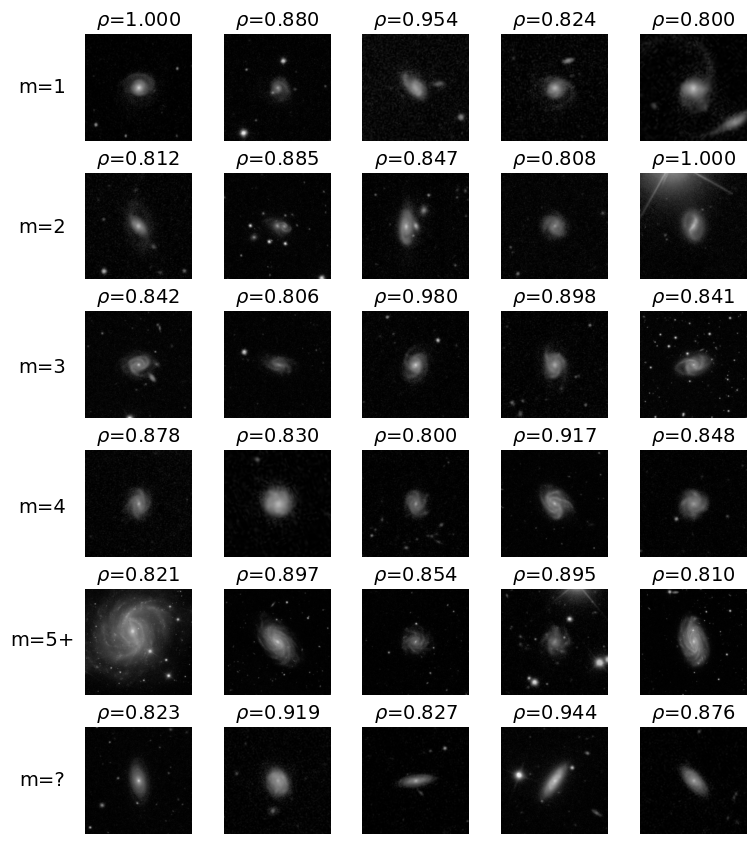

In [43]:
import textwrap

if (bVisualize):

    fonttitle = {'family':'Times New Roman','size':14}
    
    img_disp_num=5
    ClassCount=[]
    img_arr=[]
    prob_max_arr=[]
    
    aspect = 1.
    n = NUM_CLASS # number of rows
    m = img_disp_num # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    #wspace=0.1  # set to zero for no spacing
    wspace=0.3  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    #figheight= 20 # inch
    figheight= 10 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    #plt.rcParams["font.family"] = "Times New Roman"
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)

    for i in range (NUM_CLASS):
        ClassCount.append(0)
        img_arr.append([])
        prob_max_arr.append([])
    
    total_i=0
    for images, labels in train_dataset_ori:
        i=0
        for item in labels:
            nClass=int(item)
            ClassCount[nClass]+=1

            if (ClassCount[nClass]<=img_disp_num): 
                #print('nClass: {}'.format(nClass))
                #print('ClassIdx: {}'.format(ClassIdx[nClass]))
                nIdx=nClass*img_disp_num + ClassCount[nClass]
                #print('nIdx: {}'.format(nIdx))
                ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)
                #plt.subplots_adjust(hspace=0.2,wspace=0)

                if (bGrayscale == True):
                    img = images[i]*255
                    img=img.numpy().astype("uint8")
                    #plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
                else:
                    img=images[i].numpy().astype("uint8")
                    #plt.imshow(img.squeeze())

                img_arr[nClass].append(img)
                prob_max_arr[nClass].append(prob_max_train[total_i])

            i+=1
            total_i+=1

            
    for i, ax in enumerate(axes.flatten()):
        classidx=int(i/img_disp_num)
        idx=i%img_disp_num
        if (bZoobot is False):
            ax.imshow(img_arr[classidx][idx].squeeze())
        else:
            ax.imshow(img_arr[classidx][idx].squeeze(),cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
        txt = r"$\rho$={:.3f}".format(prob_max_arr[classidx][idx])
        ax.set_title(txt, fontdict=fonttitle)

    adjust=[0.4,0.45,0.5,0.55,0.55,0.6]
    # Add row titles at the left of each row
    for row in range(NUM_CLASS):
        max_width=10
        wrapped_title = "\n".join(textwrap.wrap(f"m={x_label[row]}", width=max_width))
        y_position = fig.subplotpars.top - (row + adjust[row]) * (fig.subplotpars.top - fig.subplotpars.bottom) / NUM_CLASS
        fig.text(
            0.00,  # x-coordinate for left alignment
            y_position,  # y-position for each row
            wrapped_title,  # Customize row title as needed
            va='center',
            ha='center',
            rotation=0,
            fontdict=fonttitle
        )

    '''
    plt.savefig('visualization_ori.png', dpi=1000, bbox_inches="tight", format='png')
    plt.savefig('visualization_ori.tif', dpi=1000, bbox_inches="tight", format='tiff')
    plt.savefig('visualization_ori.svg', bbox_inches="tight", format='svg')
    plt.savefig('visualization_ori.eps', bbox_inches="tight", format='eps')
    '''
    plt.savefig('visualization_ori.pdf', bbox_inches="tight", format='pdf')

import matplotlib.pyplot as plt
x=0
i=0
#plt.figure(figsize=(10, 10))
#plt.figure()
for images, labels in train_dataset_ori.take(1):
    #for i in range(9):
    while (i<len(labels) and x<9):
        if (int(labels[i])==3):
            ax = plt.subplot(3, 3, x+1)
            img = images[i]*255
            img=img.numpy().astype("uint8")
            if (bGrayscale == True):
                plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
            else:
                plt.imshow(img.squeeze())
            #print(img)
            #plt.imshow(img)
            #print(labels[i])
            plt.title(int(labels[i]))
            plt.axis("off")
            x+=1
        i+=1

if (bVisualize):

    img_disp_num=5
    ClassIdx=[]

    plt.figure(figsize=(20, 20))

    for i in range (NUM_CLASS):
        ClassIdx.append(0)

    for images, labels in train_dataset_resize:
        i=0
        for item in labels:
            nClass=int(item)
            ClassIdx[nClass]+=1

            if (ClassIdx[nClass]<=img_disp_num): 
                #print('nClass: {}'.format(nClass))
                #print('ClassIdx: {}'.format(ClassIdx[nClass]))
                nIdx=nClass*img_disp_num + ClassIdx[nClass]
                #print('nIdx: {}'.format(nIdx))
                ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)

                if (bGrayscale == True):
                    img = images[i]*255
                    img=img.numpy().astype("uint8")
                    plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
                else:
                    img=images[i].numpy().astype("uint8")
                    plt.imshow(img.squeeze())

                plt.title(nClass)
                plt.axis("off")
            i+=1

if (bVisualize):

    img_disp_num=5
    ClassIdx=[]

    plt.figure(figsize=(20, 20))

    for i in range (NUM_CLASS):
        ClassIdx.append(0)

    for images, labels in train_dataset_resize:

        augmented_images = data_augmentation(images)

        i=0
        for item in labels:
            nClass=int(item)
            ClassIdx[nClass]+=1

            if (ClassIdx[nClass]<=img_disp_num): 
                #print('nClass: {}'.format(nClass))
                #print('ClassIdx: {}'.format(ClassIdx[nClass]))
                nIdx=nClass*img_disp_num + ClassIdx[nClass]
                #print('nIdx: {}'.format(nIdx))
                ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)

                if (bGrayscale == True):
                    img = images[i]*255
                    img=img.numpy().astype("uint8")
                    plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
                else:
                    img=images[i].numpy().astype("uint8")
                    plt.imshow(img.squeeze())

                plt.title(nClass)
                plt.axis("off")
            i+=1

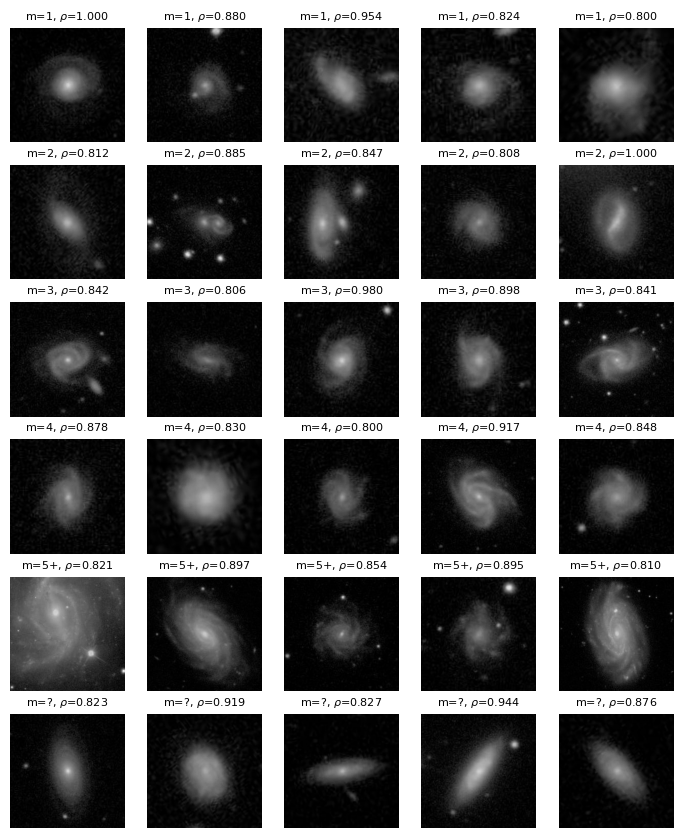

In [44]:
if (bVisualize):

    fonttitle = {'family':'Times New Roman','size':8}
    
    img_disp_num=5
    ClassCount=[]
    img_arr=[]
    prob_max_arr=[]
    
    aspect = 1.
    n = NUM_CLASS # number of rows
    m = img_disp_num # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    wspace=0.2  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    #figheight= 20 # inch
    figheight= 10 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    plt.rcParams["font.family"] = "Times New Roman"
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)

    for i in range (NUM_CLASS):
        ClassCount.append(0)
        img_arr.append([])
        prob_max_arr.append([])
    
    total_i=0
    for images, labels in train_dataset_resize:
        i=0
        for item in labels:
            nClass=int(item)
            ClassCount[nClass]+=1

            if (ClassCount[nClass]<=img_disp_num): 
                #print('nClass: {}'.format(nClass))
                #print('ClassIdx: {}'.format(ClassIdx[nClass]))
                nIdx=nClass*img_disp_num + ClassCount[nClass]
                #print('nIdx: {}'.format(nIdx))
                ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)
                #plt.subplots_adjust(hspace=0.2,wspace=0)

                if (bGrayscale == True):
                    img = images[i]*255
                    img=img.numpy().astype("uint8")
                    #plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
                else:
                    img=images[i].numpy().astype("uint8")
                    #plt.imshow(img.squeeze())

                img_arr[nClass].append(img)
                prob_max_arr[nClass].append(prob_max_train[total_i])

            i+=1
            total_i+=1

            
    for i, ax in enumerate(axes.flatten()):
        classidx=int(i/img_disp_num)
        idx=i%img_disp_num
        if (bZoobot is False):
            ax.imshow(img_arr[classidx][idx].squeeze())
        else:
            ax.imshow(img_arr[classidx][idx].squeeze(),cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
        txt = r"m={}, $\rho$={:.3f}".format(x_label[classidx],prob_max_arr[classidx][idx])
        ax.set_title(txt, fontdict=fonttitle)
        
    plt.savefig('visualization_resize.png', dpi=1000, bbox_inches="tight", format='png')
    plt.savefig('visualization_resize.tif', dpi=1000, bbox_inches="tight", format='tiff')
    plt.savefig('visualization_resize.svg', bbox_inches="tight", format='svg')
    plt.savefig('visualization_resize.eps', bbox_inches="tight", format='eps')
    plt.savefig('visualization_resize.pdf', bbox_inches="tight", format='pdf')

In [45]:
def add_augmentation_layers(model, crop_size, resize_size, always_augment=False):
    """
    Add image augmentation layers to end of ``model``.
    
    The following augmentations are applied, in order:
        - Random rotation (aliased)
        - Random flip (horizontal and/or vertical)
        - Random crop (not centered) down to ``(crop_size, crop_size)``
        - Resize down to ``(resize_size, resize_size)``
    If crop_size is within 10 of resize_size, resizing is skipped and instead the image is cropped directly to `resize_size`.
    This is both faster and avoids information loss from aliasing.
    I strongly suggest this approach if possible.
    Args:
        model (tf.keras.Model): Model to add augmentation layers. Layers are added at *end*, so likely an empty model e.g. tf.keras.Sequential()
        crop_size (int): desired length of image after random crop (assumed square)
        resize_size (int): desired length of image after resizing (assumed square)
        always_augment (bool, optional): If True, augmentations also happen at test time. Defaults to False.
    """
    if crop_size < resize_size:
        logging.warning('Crop size {} < final size {}, losing resolution'.format(
            crop_size, resize_size))

    resize = True
    #if np.abs(crop_size - resize_size) < 10:
    #    logging.warning(
    #        'Crop size and final size are similar: skipping resizing and cropping directly to resize_size (ignoring crop_size)')
    #    resize = False
    #    crop_size = resize_size

    # np.pi fails with tf 2.5
    model.add(tf.keras.layers.RandomRotation(factor=0.5,fill_mode='reflect')) # rotation range +/- 0.25 * 2pi i.e. +/- 90*.
    model.add(tf.keras.layers.RandomFlip())
    #model.add(tf.keras.layers.RandomCrop(crop_size, crop_size))
    model.add(tf.keras.layers.RandomZoom(height_factor=(-dZoomFactor, dZoomFactor),width_factor=(-dZoomFactor, dZoomFactor)))
    #model.add(tf.keras.layers.RandomBrightness(factor=0.02))
    if resize:
        logging.info('Using resizing, to {}'.format(resize_size))
        model.add(tf.keras.layers.Resizing(
            resize_size, resize_size, interpolation='bilinear')
    )

<a id="section-thirteen"></a>
# **Training**

In [46]:
if (bZoobot == True and bGradCam!=True):
    
    #channels=1
        
    from zoobot.tensorflow.estimators import efficientnet_standard, efficientnet_custom, custom_layers

    get_effnet=efficientnet_standard.EfficientNetB0

    # get headless model (inc. augmentations)
    #base_model = define_model.load_model(
    #  checkpoint_loc,  # loading pretrained model as above
    #  expect_partial=True,  # ignores some optimizer warnings
    #  include_top=False,  # do not include the head used for GZ DECaLS, this time - we will add our own head
    #  input_size=264,  # the preprocessing above did not change size
    #  crop_size=crop_size,  # model augmentation layers apply a crop...
    #  resize_size=resize_size,  # ...and then apply a resize
    #  output_dim=None  # headless so no effect
    #)


    base_model = tf.keras.Sequential()

    input_shape = (input_size, input_size, channels)
    base_model.add(tf.keras.Input(shape=input_shape),)

    add_augmentation_layers(
        base_model,
        crop_size=crop_size,
        resize_size=resize_size,
        always_augment=always_augment
    )  # inplace

    shape_after_preprocessing_layers = (resize_size, resize_size, channels)
    # now headless
    effnet = efficientnet_custom.define_headless_efficientnet(
        input_shape=shape_after_preprocessing_layers,
        get_effnet=get_effnet,
        # further kwargs will be passed to get_effnet
        use_imagenet_weights=use_imagenet_weights,
    )
    base_model.add(effnet)

    logging.info('Model expects input of {}, adjusted to {} after preprocessing'.format(input_shape, shape_after_preprocessing_layers))

    if include_top:
        assert output_dim is not None
        base_model.add(tf.keras.layers.GlobalAveragePooling2D())
        base_model.add(custom_layers.PermaDropout(dropout_rate, name='top_dropout'))
        efficientnet_custom.custom_top_dirichlet(base_model, output_dim)  # inplace

    # will be updated by callback
    base_model.step = tf.Variable(
        0, dtype=tf.int64, name='model_step', trainable=False)

    #if weights_loc:
    #    load_weights(model, weights_loc, expect_partial=expect_partial)


    define_model.load_weights(base_model, checkpoint_loc, expect_partial=expect_partial)

    base_model.trainable = False  # freeze the headless model (no training allowed)
    
    #dLearningRate = 0.001
    '''
    if (bGradCam):
        inputs = tf.keras.Input(shape=input_shape)
        x = data_augmentation(inputs)
        #x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
        x = base_model(x, training=False)

        cnn_model = tf.keras.models.Model(inputs=inputs, outputs=x)

        # x = base_model(x)
        x = layers.InputLayer(input_shape=(7,7,1280))(x)  # base model dim before GlobalAveragePooling (ignoring batch)
        x = layers.GlobalAveragePooling2D()(x)
        # TODO the following layers may need some experimentation to find a good combination for your problem
        # layers.Dropout(0.75),
        ## layers.Dense(64, activation='relu'),
        ## layers.Dropout(0.75),
        x = layers.Dense(1024, activation='relu')(x)
        ## layers.Dropout(0.75),
        predictions = layers.Dense(NUM_CLASS, activation="softmax", name='softmax_output')(x)  # output should be one neuron w/ sigmoid for binary classification...
        ## layers.Dense(NUM_CLASS, activation="softmax", name="softmax_output")  # ...or N neurons w/ softmax for N-class classification
        model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  
    else:
    '''   

    new_head = tf.keras.Sequential([
    layers.InputLayer(input_shape=(7,7,1280)),  # base model dim before GlobalAveragePooling (ignoring batch)
    layers.GlobalAveragePooling2D(),
    # TODO the following layers may need some experimentation to find a good combination for your problem
    #layers.Dropout(0.75),
    #layers.Dense(64, activation='relu'),
    #layers.Dropout(0.75),
    layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.75),
    # layers.Dense(1, activation="sigmoid", name='sigmoid_output')  # output should be one neuron w/ sigmoid for binary classification...
    layers.Dense(NUM_CLASS, activation="softmax", name="softmax_output")  # ...or N neurons w/ softmax for N-class classification
    ])

    # stick the new head on the pretrained base model
    model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    base_model,
    new_head
    ])

In [47]:
if (bZoobot == True and bGradCam==True):
    
    #channels=1
        
    from zoobot.tensorflow.estimators import efficientnet_standard, efficientnet_custom, custom_layers

    get_effnet=efficientnet_standard.EfficientNetB0

    # get headless model (inc. augmentations)
    #base_model = define_model.load_model(
    #  checkpoint_loc,  # loading pretrained model as above
    #  expect_partial=True,  # ignores some optimizer warnings
    #  include_top=False,  # do not include the head used for GZ DECaLS, this time - we will add our own head
    #  input_size=264,  # the preprocessing above did not change size
    #  crop_size=crop_size,  # model augmentation layers apply a crop...
    #  resize_size=resize_size,  # ...and then apply a resize
    #  output_dim=None  # headless so no effect
    #)


    base_model = tf.keras.Sequential()

    input_shape = (input_size, input_size, channels)
    base_model.add(tf.keras.Input(shape=input_shape),)

    shape_after_preprocessing_layers = (resize_size, resize_size, channels)
    # now headless
    effnet = efficientnet_custom.define_headless_efficientnet(
        input_shape=shape_after_preprocessing_layers,
        get_effnet=get_effnet,
        # further kwargs will be passed to get_effnet
        use_imagenet_weights=use_imagenet_weights,
    )
    base_model.add(effnet)

    logging.info('Model expects input of {}, adjusted to {} after preprocessing'.format(input_shape, shape_after_preprocessing_layers))

    if include_top:
        assert output_dim is not None
        base_model.add(tf.keras.layers.GlobalAveragePooling2D())
        base_model.add(custom_layers.PermaDropout(dropout_rate, name='top_dropout'))
        efficientnet_custom.custom_top_dirichlet(base_model, output_dim)  # inplace

    # will be updated by callback
    base_model.step = tf.Variable(
        0, dtype=tf.int64, name='model_step', trainable=False)

    #if weights_loc:
    #    load_weights(model, weights_loc, expect_partial=expect_partial)


    define_model.load_weights(base_model, checkpoint_loc, expect_partial=expect_partial)

    base_model.trainable = False  # freeze the headless model (no training allowed)
    
    #dLearningRate = 0.001 
    
    
    # x = base_model(x)
    #x = layers.InputLayer(input_shape=(7,7,1280))(x)  # base model dim before GlobalAveragePooling (ignoring batch)
    x = layers.GlobalAveragePooling2D()(base_model.layers[-1].layers[-1].output)
    # TODO the following layers may need some experimentation to find a good combination for your problem
    # layers.Dropout(0.75),
    ## layers.Dense(64, activation='relu'),
    ## layers.Dropout(0.75),
    x = layers.Dense(1024, activation='relu')(x)
    ## layers.Dropout(0.75),
    predictions = layers.Dense(NUM_CLASS, activation="softmax", name='softmax_output')(x)  # output should be one neuron w/ sigmoid for binary classification...
    ## layers.Dense(NUM_CLASS, activation="softmax", name="softmax_output")  # ...or N neurons w/ softmax for N-class classification

    model = tf.keras.models.Model(base_model.layers[-1].layers[-1].input, predictions)

In [48]:
if (bZoobot != True and bGradCam!=True):
    #channels = 3
    
    input_shape = (input_size, input_size, channels)
        
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(resize_size, resize_size) + (channels,))

    base_model.trainable = True  # freeze the headless model (no training allowed)
    
    #dLearningRate = 0.0001
    
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    #x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    
    cnn_model = tf.keras.models.Model(inputs=inputs, outputs=x)
        
    # x = base_model(x)
    x = layers.InputLayer(input_shape=(7,7,1280))(x)  # base model dim before GlobalAveragePooling (ignoring batch)
    x = layers.GlobalAveragePooling2D()(x)
    # TODO the following layers may need some experimentation to find a good combination for your problem
    # layers.Dropout(0.75),
    ## layers.Dense(64, activation='relu'),
    ## layers.Dropout(0.75),
    x = layers.Dense(1024, activation='relu')(x)
    ## layers.Dropout(0.75),
    predictions = layers.Dense(NUM_CLASS, activation="softmax", name='softmax_output')(x)  # output should be one neuron w/ sigmoid for binary classification...
    ## layers.Dense(NUM_CLASS, activation="softmax", name="softmax_output")  # ...or N neurons w/ softmax for N-class classification

    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [49]:
if (bZoobot != True and bGradCam==True):
    #channels = 3
    
    input_shape = (input_size, input_size, channels)
        
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze all layers except Batch Normalization layers
    for layer in base_model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    
    #dLearningRate = 0.0001
    
    #inputs = tf.keras.Input(shape=input_shape)
    #x = data_augmentation(inputs)
    #x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    #bm_output = base_model(inputs, training=False)
    
    #cnn_model = tf.keras.models.Model(inputs=inputs, outputs=x)
        
    # x = base_model(x)
    #x = layers.InputLayer(input_shape=(7,7,1280))(x)  # base model dim before GlobalAveragePooling (ignoring batch)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # TODO the following layers may need some experimentation to find a good combination for your problem
    # layers.Dropout(0.75),
    ## layers.Dense(64, activation='relu'),
    ## layers.Dropout(0.75),
    x = layers.Dense(1024, activation='relu')(x)
    ## layers.Dropout(0.75),
    predictions = layers.Dense(NUM_CLASS, activation="softmax", name='softmax_output')(x)  # output should be one neuron w/ sigmoid for binary classification...
    ## layers.Dense(NUM_CLASS, activation="softmax", name="softmax_output")  # ...or N neurons w/ softmax for N-class classification

    model = tf.keras.models.Model(base_model.input, predictions)

resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False
    
fc1 = Dense(100)(resnet.layers[-1].output)
fc2 = Dense(100)(fc1)
logits = Dense(2)(fc2)
output = Activation('softmax')(logits)
model_with_fc = Model(resnet.input, output)

In [50]:
if (bLoadModelEval==False):
    
    # log_file = 'finetune_minimal'
    # log_path = os.path.join(output_dir, log_file)

    # if not os.path.isdir(log_path):
    #   os.mkdir(log_path)

    log_dir = 'results/finetune_minimal' 


    #loss = tf.keras.losses.binary_crossentropy

    model.compile(
        # loss=loss,
        loss = ['categorical_crossentropy'], 
        optimizer=tf.keras.optimizers.Adam(learning_rate=dLearningRate),  # normal learning rate is okay
        #optimizer=tf.keras.optimizers.legacy.SGD(
        #learning_rate=0.001,
        #momentum=0.0005
        #),
        metrics=['accuracy']

    )
    #model.summary()


    callbacks = [
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(log_dir, 'tensorboard'),
            histogram_freq=0,  # don't log all the internal histograms, possibly slow
            write_images=False,  # this actually writes the weights, terrible name
            write_graph=False,
            # profile_batch='2,10' 
            profile_batch=0   # i.e. disable profiling
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=log_dir,
            monitor=cb_monitor,
            mode=cb_mode,
            save_freq='epoch',
            save_best_only=True,
            save_weights_only=True,
            ),
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=es_patience, monitor=cb_monitor,),
        tf.keras.callbacks.TerminateOnNaN(),
        # custom_callbacks.UpdateStepCallback(
        #     batch_size=next(iter(train_dataset))[0].shape[0]  # grab the first batch, 0th tuple element (the images), 0th dimension, to check the batch size
        # )
    ]


    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        callbacks=callbacks,
                        class_weight=class_weight,
                        #validation_split=0.3,
                        #callbacks=[stop_early]
                        #model_checkpoint]
                        )


    best_acc = max(history.history["val_accuracy"])
    best_loss = min(history.history["val_loss"])
    print(best_acc)
    print(best_loss)

Epoch 1/50
49/49 [==============================] - 46s 775ms/step - loss: 1.3490 - accuracy: 0.6756 - val_loss: 1.0133 - val_accuracy: 0.7404
Epoch 2/50
49/49 [==============================] - 35s 705ms/step - loss: 0.8613 - accuracy: 0.7854 - val_loss: 0.7514 - val_accuracy: 0.7876
Epoch 3/50
49/49 [==============================] - 37s 762ms/step - loss: 0.6832 - accuracy: 0.8072 - val_loss: 0.6389 - val_accuracy: 0.7935
Epoch 4/50
49/49 [==============================] - 35s 708ms/step - loss: 0.5919 - accuracy: 0.8097 - val_loss: 0.5786 - val_accuracy: 0.8171
Epoch 5/50
49/49 [==============================] - 35s 703ms/step - loss: 0.5385 - accuracy: 0.8263 - val_loss: 0.5405 - val_accuracy: 0.8230
Epoch 6/50
49/49 [==============================] - 34s 699ms/step - loss: 0.5056 - accuracy: 0.8378 - val_loss: 0.5115 - val_accuracy: 0.8319
Epoch 7/50
49/49 [==============================] - 34s 689ms/step - loss: 0.4878 - accuracy: 0.8455 - val_loss: 0.4910 - val_accuracy: 0.8348

In [51]:
#%load_ext tensorboard
#%tensorboard --logdir='/kaggle/working/results/finetune_minimal/tensorboard'

<a id="section-fourteen"></a>
# **Evaluation**

In [52]:
if (bLoadModelEval):
    log_dir = model_path

In [54]:
if (bZoobot):
    if (bGradCam==False):
        # stick the new head on the pretrained base model
        best_model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        base_model,
        new_head
        ])
    else:
        best_model = tf.keras.models.Model(base_model.layers[-1].layers[-1].input, outputs=predictions)
else:
    if (bGradCam==False):
        best_model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    else:
        best_model = tf.keras.models.Model(base_model.input, predictions)


best_model.compile(
    # loss=loss,
    loss = ['categorical_crossentropy'], 
    optimizer=tf.keras.optimizers.Adam(learning_rate=dLearningRate),  # normal learning rate is okay
    #optimizer=tf.keras.optimizers.legacy.SGD(
    #learning_rate=0.001,
    #momentum=0.0005
    #),
    metrics=['accuracy']
    
)
        
best_model.load_weights(log_dir)  # Load the best weights


#if (bGradCam):
#    cnn_model.load_weights(log_dir)

In [55]:
best_model.load_weights(log_dir)  # Load the best weights

In [56]:
#best_model.compile(
#    # loss=loss,
#    loss = ['categorical_crossentropy'], 
#    optimizer=tf.keras.optimizers.Adam(learning_rate=dLearningRate),  # normal learning rate is okay
#    #optimizer=tf.keras.optimizers.legacy.SGD(
#    #learning_rate=0.001,
#    #momentum=0.0005
#    #),
#    metrics=['accuracy']
#    
#)


# evaluate performance on val set, repeating to marginalise over any test-time augmentations or dropout:
losses = []
accs = []
for _ in range(5):
  loss, acc = best_model.evaluate(val_dataset)
  losses.append(loss)
  accs.append(acc)
print('Mean validation loss: {:.3f} (var {:.4f})'.format(np.mean(losses), np.var(losses)))
print('Mean validation accuracy: {:.3f} (var {:.4f})'.format(np.mean(accs), np.var(accs)))

'''
# evaluate performance on val set, repeating to marginalise over any test-time augmentations or dropout:
losses = []
accs = []
for _ in range(5):
  loss, acc = best_model.evaluate(test_dataset)
  losses.append(loss)
  accs.append(acc)
print('Mean testing loss: {:.3f} (var {:.4f})'.format(np.mean(losses), np.var(losses)))
print('Mean testing accuracy: {:.3f} (var {:.4f})'.format(np.mean(accs), np.var(accs)))
'''

22/22 [==============================] - 9s 405ms/step - loss: 0.4381 - accuracy: 0.8584
Mean validation loss: 0.438 (var 0.0000)
Mean validation accuracy: 0.858 (var 0.0000)


"\n# evaluate performance on val set, repeating to marginalise over any test-time augmentations or dropout:\nlosses = []\naccs = []\nfor _ in range(5):\n  loss, acc = best_model.evaluate(test_dataset)\n  losses.append(loss)\n  accs.append(acc)\nprint('Mean testing loss: {:.3f} (var {:.4f})'.format(np.mean(losses), np.var(losses)))\nprint('Mean testing accuracy: {:.3f} (var {:.4f})'.format(np.mean(accs), np.var(accs)))\n"

In [57]:
if (bLoadModelEval==False):
    shutil.make_archive(os.path.join('/kaggle/working',project_name),'zip','/kaggle/working/results')

In [58]:
shutil.make_archive(os.path.join('/kaggle/working',project_name),'zip','/kaggle/working/results')

'/kaggle/working/zoobot_merge3_4.zip'

In [59]:
val_dataset_test=val_dataset.unbatch()
val_dataset_test=val_dataset_test.batch(1)


ds_labels = []
ds_pred = []

for images, labels in val_dataset_test:
   ds_labels.append(labels) # or labels.numpy().argmax() for int labels

# original label
Y_test = np.array(ds_labels)
print(Y_test.shape)

# prediction
Y_pred = best_model.predict(val_dataset_test)
print(Y_pred.shape)

# remove array
Y_test2=np.squeeze(Y_test)
print(Y_test2.shape)

#Y_pred2=np.squeeze(Y_pred)
Y_pred2=Y_pred
print(Y_pred2.shape)

# convert from array into int
Y_test3 = np.argmax(Y_test2, axis=1)
print(Y_test2.shape)

prob_pred=[]
for item in Y_pred2:
    prob_pred.append(max(item))

Y_pred3 = np.argmax(Y_pred2, axis=1)
print(Y_pred2.shape)

cm=confusion_matrix(Y_test3, Y_pred3)

print(classification_report(Y_test3, Y_pred3, digits=4))
print(cm)

(339, 1, 6)
339/339 [==============================] - 16s 44ms/step
(339, 6)
(339, 6)
(339, 6)
(339, 6)
(339, 6)
              precision    recall  f1-score   support

           0     0.9318    0.8200    0.8723        50
           1     0.8105    0.8556    0.8324        90
           2     0.8352    0.8444    0.8398        90
           3     1.0000    0.2222    0.3636         9
           4     1.0000    0.9000    0.9474        10
           5     0.8776    0.9556    0.9149        90

    accuracy                         0.8584       339
   macro avg     0.9092    0.7663    0.7951       339
weighted avg     0.8634    0.8584    0.8531       339

[[41  3  1  0  0  5]
 [ 2 77  7  0  0  4]
 [ 0 12 76  0  0  2]
 [ 0  0  6  2  0  1]
 [ 0  0  1  0  9  0]
 [ 1  3  0  0  0 86]]


In [60]:
test_dataset_test=test_dataset.unbatch()
test_dataset_test=test_dataset_test.batch(1)


ds_labels = []
ds_pred = []

for images, labels in test_dataset_test:
   ds_labels.append(labels) # or labels.numpy().argmax() for int labels

# original label
Y_test_test = np.array(ds_labels)
print(Y_test_test.shape)

# prediction
Y_pred_test = best_model.predict(test_dataset_test)
print(Y_pred_test.shape)

# remove array
Y_test2_test=np.squeeze(Y_test_test)
print(Y_test2_test.shape)

#Y_pred2=np.squeeze(Y_pred)
Y_pred2_test=Y_pred_test
print(Y_pred2_test.shape)

# convert from array into int
Y_test3_test = np.argmax(Y_test2_test, axis=1)
print(Y_test3_test.shape)

prob_pred_test=[]
for item in Y_pred2_test:
    prob_pred_test.append(max(item))

Y_pred3_test = np.argmax(Y_pred2_test, axis=1)
print(Y_pred2_test.shape)

cm_test=confusion_matrix(Y_test3_test, Y_pred3_test)

print(classification_report(Y_test3_test, Y_pred3_test, digits=4))
print(cm_test)

(10596, 1, 6)
   1684/Unknown - 71s 42ms/step

KeyboardInterrupt: 

In [ ]:
train_dataset_test=train_dataset.unbatch()
train_dataset_test=train_dataset_test.batch(1)


ds_labels = []
ds_pred = []

for images, labels in train_dataset_test:
   ds_labels.append(labels) # or labels.numpy().argmax() for int labels

# original label
Y_test_train = np.array(ds_labels)
print(Y_test_train.shape)

# prediction
Y_pred_train = best_model.predict(train_dataset_test)
print(Y_pred_train.shape)

# remove array
Y_test2_train=np.squeeze(Y_test_train)
print(Y_test2_train.shape)

#Y_pred2=np.squeeze(Y_pred)
Y_pred2_train=Y_pred_train
print(Y_pred2_train.shape)

# convert from array into int
Y_test3_train = np.argmax(Y_test2_train, axis=1)
print(Y_test3_train.shape)

prob_pred_train=[]
for item in Y_pred2_train:
    prob_pred_train.append(max(item))

Y_pred3_train = np.argmax(Y_pred2_train, axis=1)
print(Y_pred2_train.shape)

cm_train=confusion_matrix(Y_test3_train, Y_pred3_train)

print(classification_report(Y_test3_train, Y_pred3_train, digits=4))
print(cm_train)

<a id="section-twenty-one"></a>
# **Confusion Matrix**

In [ ]:
import textwrap
def wrap_labels(labels, width, break_long_words=False):
    labels_new = []
    for label in labels:
        text = label
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    #ax.set_xticklabels(labels, rotation=0)
    
    return labels_new

In [ ]:
target_names=[
                '1 spiral arm',
                '2 spiral arms',
                '3 spiral arms',
                '4 spiral arms',
                #'3 spiral arms + 4 spiral arms',
                'more than 4 spiral arms',
                #'4 spiral arms + more than 4 spiral arms',
                'cant tell',
            ]

break_width=15
break_long_words=False

target_names_new=[]
for item in target_names:
    new_text = textwrap.fill(item, width=break_width,
                          break_long_words=break_long_words)
    target_names_new.append(new_text)

In [ ]:
import seaborn as sns

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.4f'
            , xticklabels=target_names_new
            , yticklabels=target_names_new
           )


plt.xticks(rotation=0) 

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt_path=os.path.join('/kaggle/working', project_name+'_cmn')

plt.savefig(plt_path+'.tiff'
            ,format='tiff'
            ,dpi=1000
           )

plt.show(block=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True
            , xticklabels=target_names_new
            , yticklabels=target_names_new
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt_path=os.path.join('/kaggle/working', project_name+'_cm')

plt.savefig(plt_path+'.tiff'
            ,format='tiff'
            ,dpi=1000
            ,bbox_inches='tight'
           )
plt.show(block=False)

import seaborn as sns

# Normalise
cmn_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn_test, annot=True, fmt='.4f'
            , xticklabels=target_names_new
            , yticklabels=target_names_new
           )


plt.xticks(rotation=0) 

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt_path=os.path.join('/kaggle/working', project_name+'_cmn_test')

plt.savefig(plt_path+'.tiff'
            ,format='tiff'
            ,dpi=1000
           )

plt.show(block=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_test, annot=True
            , xticklabels=target_names_new
            , yticklabels=target_names_new
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt_path=os.path.join('/kaggle/working', project_name+'_cm_test')

plt.savefig(plt_path+'.tiff'
            ,format='tiff'
            ,dpi=1000
            ,bbox_inches='tight'
           )
plt.show(block=False)

<a id="section-twenty-three"></a>
# **Analysis:: Physical Properties**

In [ ]:
if (bPhysicalProp):
    label_se=pd.Series(Y_test3,name='label')
    pred_se=pd.Series(Y_pred3,name='pred')
    '''
    tight_se=pd.Series(tight_train,name='tight')
    loose_se=pd.Series(loose_train,name='loose')
    bar_se=pd.Series(bar_train,name='bar')
    unbar_se=pd.Series(unbar_train,name='unbar')
    '''
    
    mass_se=pd.Series(mass_val,name='mass')
    SFR_se=pd.Series(SFR_val,name='SFR')

    df_analy=pd.concat([label_se,pred_se,mass_se,SFR_se],axis=1)
    
    df_analy.head()
    
    df_analy.to_csv("analysis_val.csv", sep='\t')

In [ ]:
if (bPhysicalProp):
    label_se=pd.Series(Y_test3_test,name='label')
    pred_se=pd.Series(Y_pred3_test,name='pred')
    '''
    tight_se=pd.Series(tight_train,name='tight')
    loose_se=pd.Series(loose_train,name='loose')
    bar_se=pd.Series(bar_train,name='bar')
    unbar_se=pd.Series(unbar_train,name='unbar')
    '''
    
    mass_se=pd.Series(mass_test,name='mass')
    SFR_se=pd.Series(SFR_test,name='SFR')

    df_analy_test=pd.concat([label_se,pred_se,mass_se,SFR_se],axis=1)
    
    df_analy_test.head()
    
    df_analy_test.to_csv("analysis_test.csv", sep='\t')

In [ ]:
if (bPhysicalProp):
    label_se=pd.Series(Y_test3_train,name='label')
    pred_se=pd.Series(Y_pred3_train,name='pred')
    '''
    tight_se=pd.Series(tight_train,name='tight')
    loose_se=pd.Series(loose_train,name='loose')
    bar_se=pd.Series(bar_train,name='bar')
    unbar_se=pd.Series(unbar_train,name='unbar')
    '''
    
    mass_se=pd.Series(mass_train,name='mass')
    SFR_se=pd.Series(SFR_train,name='SFR')

    df_analy_train=pd.concat([label_se,pred_se,mass_se,SFR_se],axis=1)
    
    df_analy_train.head()
    
    df_analy_train.to_csv("analysis_train.csv", sep='\t')

In [ ]:
if (bPhysicalProp):

    Y_test3_total = list(Y_test3)+list(Y_test3_test)+list(Y_test3_train)
    Y_pred3_total = list(Y_pred3)+list(Y_pred3_test)+list(Y_pred3_train)

    cm=confusion_matrix(Y_test3_total, Y_pred3_total)

    print(classification_report(Y_test3_total, Y_pred3_total, digits=4))
    print(cm)

if (bPhysicalProp):
    label_se_train=pd.Series(Y_test3_train,name='label')
    pred_se_train=pd.Series(Y_pred3_train,name='pred')
    '''
    tight_se=pd.Series(tight_train,name='tight')
    loose_se=pd.Series(loose_train,name='loose')
    bar_se=pd.Series(bar_train,name='bar')
    unbar_se=pd.Series(unbar_train,name='unbar')
    '''
    
    mass_se_train=pd.Series(mass_train,name='mass')
    SFR_se_train=pd.Series(SFR_train,name='SFR')

    df_analy_train=pd.concat([label_se_train,pred_se_train,mass_se_train,SFR_se_train],axis=1)
    
    df_analy_train.head()
    
    df_analy_train.to_csv("analysis_train.csv", sep='\t')

In [ ]:
if (bPhysicalProp):
    df_analy_total=pd.concat([df_analy,df_analy_test,df_analy_train],axis=0)
    # Remove rows where mass is NaN
    df_analy_total = df_analy_total.dropna(subset=['mass'])

    pred_count=list(df_analy_total['pred'].value_counts().sort_index(axis=0))
    label_count=list(df_analy_total['label'].value_counts().sort_index(axis=0))
    
    df_analy_total.to_csv("analysis_total_clean.csv", sep='\t')

In [ ]:
if (bPhysicalProp):
    df_analy_total_ori=pd.concat([df_analy,df_analy_test,df_analy_train],axis=0)
    df_analy_total_clean = df_analy_total_ori.dropna(subset=['mass'])
    num_rows_ori = df_analy_total_ori.shape[0]
    num_rows_clean = df_analy_total_clean.shape[0]
    
    print(num_rows_ori, num_rows_clean)

if (bPhysicalProp):
    mass=list(df_analy_total['mass'])
    class_titles=['m=1','m=2','m=3','m=4','m=5+','cant tell']
    plot_color=['darkorange','red','magenta','green','blue','blueviolet']

    #fig, axes = plt.subplots(nrows=2, ncols=NUM_CLASS, figsize=(28,8))
    fig, axes = plt.subplots(nrows=2, ncols=NUM_CLASS, figsize=(25,5))

    for i in range (NUM_CLASS):
        pred_class=df_analy_total[df_analy_total['pred']==i]
        mass_class=list(pred_class['mass'])
        ax = axes[0,i]
        _, bins, _ = ax.hist(mass, bins=20, density=True, alpha=0.6, fc='gray')
        _ = ax.hist(mass_class, bins=bins, density=True, histtype='step', alpha=0.9, lw=3,
                    #range=(10,11.5),
                    ec=plot_color[i])

        title='Pred: ' + class_titles[i] + ' ({})'.format(pred_count[i])
        ax.set_title(title,fontsize = 15)
        ax.set_ylabel('Density')
        ax.set_xlabel('Stellar mass')


        pred_class=df_analy_total[df_analy_total['label']==i]
        mass_class=list(pred_class['mass'])
        ax = axes[1,i]
        _, bins, _ = ax.hist(mass, bins=20, density=True, alpha=0.6, fc='gray')
        _ = ax.hist(mass_class, bins=bins, density=True, histtype='step', alpha=0.9, lw=3,
                    #range=(10,11.5),
                    ec=plot_color[i])

        title='Label: ' + class_titles[i] + ' ({})'.format(label_count[i])
        ax.set_title(title,fontsize = 15)
        ax.set_ylabel('Density')
        ax.set_xlabel('Stellar mass')    

    plt.tight_layout()


    filename=project_name+'_physical_ori'
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', bbox_inches="tight", format='pdf')

if (bPhysicalProp):
    mass=list(df_analy_total['mass'])
    class_titles=['m=1','m=2','m=3','m=4','m=5+','cant tell']
    plot_color=['darkorange','red','magenta','green','blue','blueviolet']

    fig, axes = plt.subplots(nrows=2, ncols=NUM_CLASS, figsize=(28,8))
    
    
    # Calculate histogram with density and get bin edges
    hist_vals, bins = np.histogram(mass, bins=20, density=True)
    # Define your density threshold
    density_threshold = 0.02

    # Find the bins where the density exceeds the threshold
    valid_bins = bins[:-1][hist_vals > density_threshold]

    # Set the plot range to cover the bins that exceed the threshold
    if len(valid_bins) > 0:
        plot_range = (min(valid_bins), max(valid_bins))
    else:
        plot_range = (min(bins), max(bins))  # fallback to full range if no valid bins
        
    print(plot_range)

    
    for i in range (NUM_CLASS):
        pred_class=df_analy_total[df_analy_total['pred']==i]
        mass_class=list(pred_class['mass'])
        ax = axes[0,i]
        _, bins, _ = ax.hist(mass, bins=20, density=True, alpha=0.6, fc='gray', range=plot_range)
        _ = ax.hist(mass_class, bins=bins, density=True, histtype='step', alpha=0.9, lw=3,
                    #range=(10,11.5),
                    ec=plot_color[i])

        title='Pred: ' + class_titles[i] + ' ({})'.format(pred_count[i])
        ax.set_title(title,fontsize = 15)
        ax.set_ylabel('Density')
        ax.set_xlabel(r'Stellar mass ($\log(M_* / M_\odot)$')
        #ax.set_ylim(0,2.55)
        ax.set_ylim(0,2.3)


        pred_class=df_analy_total[df_analy_total['label']==i]
        mass_class=list(pred_class['mass'])
        ax = axes[1,i]
        _, bins, _ = ax.hist(mass, bins=20, density=True, alpha=0.6, fc='gray', range=plot_range)
        _ = ax.hist(mass_class, bins=bins, density=True, histtype='step', alpha=0.9, lw=3,
                    #range=(10,11.5),
                    ec=plot_color[i])

        title='Label: ' + class_titles[i] + ' ({})'.format(label_count[i])
        ax.set_title(title,fontsize = 15)
        ax.set_ylabel('Density')
        ax.set_xlabel(r'Stellar mass ($\log(M_* / M_\odot)$')
        #ax.set_ylim(0,2.55)
        ax.set_ylim(0,2.3)

    plt.tight_layout()

    filename=project_name+'_physical_002'
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', bbox_inches="tight", format='pdf')

<a id="section-fifteen"></a>
# **Analysis:: Misclassification**

In [ ]:
if (bMisclassify==True):

    val_dataset_test=val_dataset.unbatch()
    val_dataset_test=val_dataset_test.batch(1)
    
    pass_img=[]
    pass_label=[]
    pass_pred=[]
    pass_prob_max=[]
    pass_prob_pred=[]
    pass_label_ori=[]
    pass_dict_class=[]
    
    for j in range (NUM_CLASS):
        pass_dict_class.append([])

    fail_img=[]
    fail_label=[]
    fail_pred=[]
    fail_prob_max=[]
    fail_prob_pred=[]
    fail_label_ori=[]
    fail_dict_class=[]
    
    for j in range (NUM_CLASS):
        fail_dict_class.append([])


    i=0
    i_pass=0
    i_fail=0
    for images, labels in val_dataset_test:
        '''
        Y_pred=best_model.predict(images, verbose = 0)
        Y_pred2=np.argmax(Y_pred, axis=1)
        Y_test=labels
        Y_test2=np.argmax(Y_test, axis=1)

        Y_pred3=Y_pred2.squeeze()
        Y_test3=Y_test2.squeeze()
        '''

        if (Y_pred3[i] == Y_test3[i]):
            #print("pass")
            pass_img.append(images)
            pass_label.append(Y_test3[i])
            pass_pred.append(Y_pred3[i])
            pass_prob_max.append(prob_max_val[i])
            pass_prob_pred.append(prob_pred[i])
            pass_label_ori.append(labels_val[i])
            pass_dict={'score_label':prob_max_val[i],'score_pred':prob_pred[i],'index':i_pass}
            pass_dict_class[labels_val[i]].append(pass_dict)

            i_pass+=1
            
        else:
            #print("fail")
            fail_img.append(images)
            fail_label.append(Y_test3[i])
            fail_pred.append(Y_pred3[i])   
            fail_prob_max.append(prob_max_val[i])
            fail_prob_pred.append(prob_pred[i])            
            fail_label_ori.append(labels_val[i])
            fail_dict={'score_label':prob_max_val[i],'score_pred':prob_pred[i],'index':i_fail}
            fail_dict_class[labels_val[i]].append(fail_dict)
            i_fail+=1            
        i+=1


    print('correct prediction: {}', len(pass_img))        
    print('wrong prediction: {}', len(fail_img))

In [ ]:
if (bMisclassify==True):

    train_dataset_test=train_dataset.unbatch()
    train_dataset_test=train_dataset_test.batch(1)
    
    train_pass_img=[]
    train_pass_label=[]
    train_pass_pred=[]
    train_pass_prob_max=[]
    train_pass_prob_pred=[]
    train_pass_label_ori=[]
    train_pass_dict_class=[]
    
    for j in range (NUM_CLASS):
        train_pass_dict_class.append([])

    train_fail_img=[]
    train_fail_label=[]
    train_fail_pred=[]
    train_fail_prob_max=[]
    train_fail_prob_pred=[]
    train_fail_label_ori=[]
    train_fail_dict_class=[]
    
    for j in range (NUM_CLASS):
        train_fail_dict_class.append([])


    i=0
    i_pass=0
    i_fail=0
    for images, labels in train_dataset_test:
        '''
        Y_pred=best_model.predict(images, verbose = 0)
        Y_pred2=np.argmax(Y_pred, axis=1)
        Y_test=labels
        Y_test2=np.argmax(Y_test, axis=1)

        Y_pred3=Y_pred2.squeeze()
        Y_test3=Y_test2.squeeze()
        '''

        if (Y_pred3_train[i] == Y_test3_train[i]):
            #print("pass")
            train_pass_img.append(images)
            train_pass_label.append(Y_test3_train[i])
            train_pass_pred.append(Y_pred3_train[i])
            train_pass_prob_max.append(prob_max_train[i])
            train_pass_prob_pred.append(prob_pred_train[i])
            train_pass_label_ori.append(labels_train[i])
            train_pass_dict={'score_label':prob_max_train[i],'score_pred':prob_pred_train[i],'index':i_pass}
            train_pass_dict_class[labels_train[i]].append(train_pass_dict)

            i_pass+=1
            
        else:
            #print("fail")
            train_fail_img.append(images)
            train_fail_label.append(Y_test3_train[i])
            train_fail_pred.append(Y_pred3_train[i])   
            train_fail_prob_max.append(prob_max_train[i])
            train_fail_prob_pred.append(prob_pred_train[i])            
            train_fail_label_ori.append(labels_train[i])
            train_fail_dict={'score_label':prob_max_train[i],'score_pred':prob_pred_train[i],'index':i_fail}
            train_fail_dict_class[labels_train[i]].append(train_fail_dict)
            i_fail+=1            
        i+=1


    print('train correct prediction: {}', len(train_pass_img))        
    print('train wrong prediction: {}', len(train_fail_img))

In [ ]:
if (bMisclassify==True):

    test_dataset_test=test_dataset.unbatch()
    test_dataset_test=test_dataset_test.batch(1)
    
    test_pass_img=[]
    test_pass_label=[]
    test_pass_pred=[]
    test_pass_prob_max=[]
    test_pass_prob_pred=[]
    test_pass_label_ori=[]
    test_pass_dict_class=[]
    
    for j in range (NUM_CLASS):
        test_pass_dict_class.append([])

    test_fail_img=[]
    test_fail_label=[]
    test_fail_pred=[]
    test_fail_prob_max=[]
    test_fail_prob_pred=[]
    test_fail_label_ori=[]
    test_fail_dict_class=[]
    
    for j in range (NUM_CLASS):
        test_fail_dict_class.append([])


    i=0
    i_pass=0
    i_fail=0
    for images, labels in test_dataset_test:
        '''
        Y_pred=best_model.predict(images, verbose = 0)
        Y_pred2=np.argmax(Y_pred, axis=1)
        Y_test=labels
        Y_test2=np.argmax(Y_test, axis=1)

        Y_pred3=Y_pred2.squeeze()
        Y_test3=Y_test2.squeeze()
        '''

        if (Y_pred3_test[i] == Y_test3_test[i]):
            #print("pass")
            test_pass_img.append(images)
            test_pass_label.append(Y_test3_test[i])
            test_pass_pred.append(Y_pred3_test[i])
            test_pass_prob_max.append(prob_max_test[i])
            test_pass_prob_pred.append(prob_pred_test[i])
            test_pass_label_ori.append(labels_test[i])
            test_pass_dict={'score_label':prob_max_test[i],'score_pred':prob_pred_test[i],'index':i_pass}
            test_pass_dict_class[labels_test[i]].append(test_pass_dict)

            i_pass+=1
            
        else:
            #print("fail")
            test_fail_img.append(images)
            test_fail_label.append(Y_test3_test[i])
            test_fail_pred.append(Y_pred3_test[i])   
            test_fail_prob_max.append(prob_max_test[i])
            test_fail_prob_pred.append(prob_pred_test[i])            
            test_fail_label_ori.append(labels_test[i])
            test_fail_dict={'score_label':prob_max_test[i],'score_pred':prob_pred_test[i],'index':i_fail}
            test_fail_dict_class[labels_test[i]].append(test_fail_dict)
            i_fail+=1            
        i+=1


    print('test correct prediction: {}', len(test_pass_img))        
    print('test wrong prediction: {}', len(test_fail_img))

In [ ]:
total_fail_img=fail_img+train_fail_img+test_fail_img
total_fail_label=fail_label+train_fail_label+test_fail_label
total_fail_pred=fail_pred+train_fail_pred+test_fail_pred
total_fail_prob_max=fail_prob_max+train_fail_prob_max+test_fail_prob_max
total_fail_label_ori=fail_label_ori+train_fail_label_ori+test_fail_label_ori

In [ ]:
total_pass_img=pass_img+train_pass_img+test_pass_img
total_pass_label=pass_label+train_pass_label+test_pass_label
total_pass_pred=pass_pred+train_pass_pred+test_pass_pred
total_pass_prob_max=pass_prob_max+train_pass_prob_max+test_pass_prob_max
total_pass_label_ori=pass_label_ori+train_pass_label_ori+test_pass_label_ori

import textwrap

if (bMisclassify == True):

    # Create a dataset with image arrays and their labels
    pass_ds = tf.data.Dataset.from_tensor_slices((pass_img,pass_label,pass_pred,pass_prob_max))

    fail_ds = tf.data.Dataset.from_tensor_slices((fail_img,fail_label,fail_pred,fail_prob_max))
    
    #for img,label,pred,prob_max in fail_ds.take(1):
    #    print(label, prob_max)
        
        
    img_disp_num=5
    ClassCount=[]
    img_arr=[]
    prob_max_arr=[]
    pred_arr=[]

    aspect = 1.2
    n = NUM_CLASS # number of rows
    m = img_disp_num # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    wspace=0.2  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    figheight= 15 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)

    for i in range (NUM_CLASS):
        ClassCount.append(0)
        img_arr.append([])
        prob_max_arr.append([])
        pred_arr.append([])

    for images, labels, preds, prob_max in fail_ds:

        #for item in labels:
        nClass=int(labels)
        ClassCount[nClass]+=1

        if (ClassCount[nClass]<=img_disp_num): 
            #print('nClass: {}'.format(nClass))
            #print('ClassCount: {}'.format(ClassCount[nClass]))
            nIdx=nClass*img_disp_num + ClassCount[nClass]
            #print('nIdx: {}'.format(nIdx))
            ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)
            if (bGrayscale == True):
                img = images*255
                img=img.numpy().astype("uint8")
                #plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
            else:
                img=images.numpy().astype("uint8")
                #plt.imshow(img.squeeze())

            img_arr[nClass].append(img)
            prob_max_arr[nClass].append(prob_max)
            pred_arr[nClass].append(preds)

            #plt.title('label:{}  pred:{}  prob_max:{:.4f}'.format(int(labels_ori), int(preds), prob_max), fontsize=8)
            #plt.axis("off")
        i+=1

    for i, ax in enumerate(axes.flatten()):

        classidx=int(i/img_disp_num)
        idx=i%img_disp_num

        if (idx<ClassCount[classidx]):
            if (bGrayscale == False):
                ax.imshow(img_arr[classidx][idx].squeeze())
            else:
                ax.imshow(img_arr[classidx][idx].squeeze(),cmap='gray', vmin=0, vmax=255)
            ax.axis('off')
            txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
            txt2="\n".join(textwrap.wrap(txt, 16))
            #ax.set_title(txt, fontsize=5)
            ax.set_title(txt2, fontsize=10)
        else:
            ax.axis('off')
        
    filename=project_name+'_misclassify'
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', bbox_inches="tight", format='pdf')

if (bMisclassify == True):

    # Create a dataset with image arrays and their labels
    pass_ds = tf.data.Dataset.from_tensor_slices((pass_img,pass_label,pass_pred,pass_prob_max))

    fail_ds = tf.data.Dataset.from_tensor_slices((fail_img,fail_label,fail_pred,fail_prob_max))
    
    #for img,label,pred,prob_max in fail_ds.take(1):
    #    print(label, prob_max)
        
        
    img_disp_num=5
    ClassCount=[]
    img_arr=[]
    prob_max_arr=[]
    pred_arr=[]

    aspect = 1.2
    n = NUM_CLASS # number of rows
    m = img_disp_num # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    wspace=0.2  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    figheight= 15 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)

    for i in range (NUM_CLASS):
        ClassCount.append(0)
        img_arr.append([])
        prob_max_arr.append([])
        pred_arr.append([])

    for images, labels, preds, prob_max in pass_ds:

        #for item in labels:
        nClass=int(labels)
        ClassCount[nClass]+=1

        if (ClassCount[nClass]<=img_disp_num): 
            #print('nClass: {}'.format(nClass))
            #print('ClassCount: {}'.format(ClassCount[nClass]))
            nIdx=nClass*img_disp_num + ClassCount[nClass]
            #print('nIdx: {}'.format(nIdx))
            ax = plt.subplot(NUM_CLASS,img_disp_num, nIdx)
            if (bGrayscale == True):
                img = images*255
                img=img.numpy().astype("uint8")
                #plt.imshow(img.squeeze(),cmap='gray', vmin=0, vmax=255)
            else:
                img=images.numpy().astype("uint8")
                #plt.imshow(img.squeeze())

            img_arr[nClass].append(img)
            prob_max_arr[nClass].append(prob_max)
            pred_arr[nClass].append(preds)

            #plt.title('label:{}  pred:{}  prob_max:{:.4f}'.format(int(labels_ori), int(preds), prob_max), fontsize=8)
            #plt.axis("off")
        i+=1

    for i, ax in enumerate(axes.flatten()):

        classidx=int(i/img_disp_num)
        idx=i%img_disp_num

        if (idx<ClassCount[classidx]):
            if (bGrayscale == False):
                ax.imshow(img_arr[classidx][idx].squeeze())
            else:
                ax.imshow(img_arr[classidx][idx].squeeze(),cmap='gray', vmin=0, vmax=255)
            ax.axis('off')
            txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
            txt2="\n".join(textwrap.wrap(txt, 16))
            #ax.set_title(txt, fontsize=5)
            ax.set_title(txt2, fontsize=10)
        else:
            ax.axis('off')
        
    filename=project_name+'_correct'
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', bbox_inches="tight", format='pdf')

In [ ]:
if (bMisclassify == True):

    dest_folder = '/kaggle/working/misclassified5'
    dest_folder = dest_folder + '_' + project_name
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)

    dest_class_folder=[]

    for i in range (NUM_CLASS):
        class_title='Class{}'.format(i)

        dest_class_folder.append(os.path.join(dest_folder,class_title))
        if not os.path.isdir(dest_class_folder[i]):
            os.mkdir(dest_class_folder[i])


        for j in range (NUM_CLASS):
            dest_class_folder_sub=os.path.join(dest_class_folder[i],'Class{}'.format(j))
            if not os.path.isdir(dest_class_folder_sub):
                os.mkdir(dest_class_folder_sub)

    i=0



    for item in total_fail_img:
        item_tensor = tf.squeeze(item, axis=0)

        if (bZoobot):
            item_tensor = tf.squeeze(item_tensor, axis=2)

        item_np=item_tensor.numpy()
        #print(item_np.shape)
        #print(new_tensor.numpy())

        if (bZoobot==True):
            image = Image.fromarray((item_np * 255).astype(np.uint8))
        else:
            image = Image.fromarray((item_np).astype(np.uint8))

        path = os.path.join(dest_folder,'Class{}'.format(total_fail_label[i]),'Class{}'.format(total_fail_pred[i]),'{}_{}_class{}.jpg'.format(int(total_fail_prob_max[i]*100),i,int(total_fail_label_ori[i])))

        print(path)

        # Save the image to a file
        image.save(path)

        i+=1


    shutil.make_archive(dest_folder,'zip',dest_folder)

In [ ]:
if (bMisclassify == True):

    dest_folder = '/kaggle/working/correctclassified4'
    dest_folder = dest_folder + '_' + project_name
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)

    dest_class_folder=[]

    for i in range (NUM_CLASS):
        class_title='Class{}'.format(i)

        dest_class_folder.append(os.path.join(dest_folder,class_title))
        if not os.path.isdir(dest_class_folder[i]):
            os.mkdir(dest_class_folder[i])


        for j in range (NUM_CLASS):
            dest_class_folder_sub=os.path.join(dest_class_folder[i],'Class{}'.format(j))
            if not os.path.isdir(dest_class_folder_sub):
                os.mkdir(dest_class_folder_sub)

    i=0



    for item in total_pass_img:
        item_tensor = tf.squeeze(item, axis=0)

        if (bZoobot):
            item_tensor = tf.squeeze(item_tensor, axis=2)

        item_np=item_tensor.numpy()
        #print(item_np.shape)
        #print(new_tensor.numpy())

        if (bZoobot==True):
            image = Image.fromarray((item_np * 255).astype(np.uint8))
        else:
            image = Image.fromarray((item_np).astype(np.uint8))

        #image = Image.fromarray(item_np)

        path = os.path.join(dest_folder,'Class{}'.format(total_pass_label[i]),'Class{}'.format(total_pass_pred[i]),'{}_{}_class{}.jpg'.format(int(total_pass_prob_max[i]*100),i,int(total_pass_label_ori[i])))

        print(path)

        # Save the image to a file
        image.save(path)

        i+=1


    shutil.make_archive(dest_folder,'zip',dest_folder)

<a id="section-nineteen"></a>
# **Analysis:: GradCam**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def make_gradcam_heatmap(img_array, best_model, cnn_model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        best_model.inputs,
        [
            #best_model.get_layer('sequential_6').get_layer('resizing_3').output,
            cnn_model.output,
            best_model.output
        ]
    )
    
    #grad_model = tf.keras.models.Model(
    #    [best_model.inputs, best_model.get_layer(last_conv_layer_name).inputs],
    #    [best_model.get_layer(last_conv_layer_name).output, best_model.output]
    #)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    
    if (bGrayscale):
        image=img*255
        image = tf.expand_dims(image, -1)
        x1 = image.shape[0]
        x2 = image.shape[1]
        img = tf.reshape(tf.broadcast_to(image, (x1, x2, 3)),  (x1, x2, 3))

    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

In [ ]:
def generate_featmap_gradcam(images, path, ax, row_index, col_index):

    img_array=images.numpy()

    if (bGrayscale==True):
        img_disp=images.numpy().squeeze()
    else:
        img_disp=images.numpy().astype("uint8").squeeze()
        
    #calculating features_map block3a_project_conv

    gradcam_model=best_model

    '''
    #img_array_proc=proc_model(img_array)
    features1, features2, features3 = best_model.predict(img_array)

    fig = pyplot.figure()
    if (bGrayscale==True): 
        pyplot.imshow(img_disp*255,cmap='gray', vmin=0, vmax=255);
    else:
        pyplot.imshow(img_disp)

    pyplot.savefig(path.format(0))
    pyplot.close(fig)

    fig = pyplot.figure(figsize=(20,15))
    for i in range(1,17):
        pyplot.subplot(4,4,i)
        pyplot.imshow(features1[0,:,:,i-1], cmap='gray');
    pyplot.savefig(path.format(1))
    pyplot.close(fig)

    fig = pyplot.figure(figsize=(20,15))
    for i in range(1,17):
        pyplot.subplot(4,4,i)
        pyplot.imshow(features2[0,:,:,i-1], cmap='gray');    
    pyplot.savefig(path.format(2))
    pyplot.close(fig)

    fig = pyplot.figure(figsize=(20,15))
    for i in range(1,17):
        pyplot.subplot(4,4,i)
        pyplot.imshow(features3[0,:,:,i-1], cmap='gray');
    pyplot.savefig(path.format(3))
    pyplot.close(fig)

    #pyplot.show()
'''
    #---------
    # gradcam
    #---------
    # Remove last layer's softmax
    gradcam_model.layers[-1].activation = None
    #last_conv_layer_name = "top_conv"
    last_conv_layer_name = "top_activation"
    #last_conv_layer_name = "top_bn"
    #last_conv_layer_name = "block7d_add"
    
    

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, gradcam_model, last_conv_layer_name)

    #superimposed_img = save_and_display_gradcam(img_array_proc.numpy().squeeze(), heatmap, 0.3)
    superimposed_img = save_and_display_gradcam(img_disp.squeeze(), heatmap, 0.8)
    
    
    return img_disp, superimposed_img

In [ ]:
from tensorflow.keras import activations
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

def class_score(output, class_index):
    return output[:,class_index]

def score(class_index):
    return lambda x: class_score(x, class_index)

def model_modifier(m):
    m.layers[-1].activation = activations.linear
    return m

def generate_featmap_gradcam(cam_model, img, classIdx):

    img_array=img.numpy()

    if (bGrayscale==True):
        img_disp=img.numpy().squeeze()
    else:
        img_disp=img.numpy().astype("uint8").squeeze()
        
    #---------
    # gradcam
    #---------
    gradcam = GradcamPlusPlus(cam_model,
                              model_modifier=model_modifier,
                              clone=True)

    # Generate heatmap with GradCAM++
    cam = gradcam(score(classIdx),
                  img,
                  penultimate_layer=-1)

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    #---------
    # gradcam
    #---------
    gradcam = GradcamPlusPlus(cam_model,
                              model_modifier=model_modifier,
                              clone=True)

    # Generate heatmap with GradCAM++
    cam = gradcam(score(classIdx),
                  img,
                  penultimate_layer=-1)

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    #---------
    # SmoothGrad
    #---------
    
    # Create Saliency object.
    saliency = Saliency(cam_model,
                        model_modifier=model_modifier,
                        clone=True)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(score(classIdx),
                            img,
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.

    return img_disp, heatmap, saliency_map

In [ ]:
from matplotlib import pyplot
import matplotlib as mpl
import cv2
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # Type 3 fonts (Type 42 keeps text as text)
rcParams['pdf.compression'] = 0  # Turn off compression
EXAM_CLASS=2

aspect = 1
bottom = 0.1; left=0.05
top=1.-bottom; right = 1.-0.18
fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
#widthspace, relative to subplot size
wspace=0.2  # set to zero for no spacing
hspace=wspace/float(aspect)
#fix the figure height
figheight= 3 # inch

if (bGradCam==True):
    sorted_list = sorted(pass_dict_class[EXAM_CLASS], key=lambda x: x['score_pred'], reverse=True)
    EXAM_IDX = sorted_list[0]['index']

    if (bZoobot==True):
        layer_names=['block2a_activation','block3a_activation','block5a_activation']
    else:
        layer_names=['block2a_expand_activation','block3a_expand_activation','block5a_expand_activation']
         
    layer_title=['lower layer','middle layer','upper layer']
    outputs = [best_model.get_layer(name).output for name in layer_names]
    model_filter = tf.keras.Model( inputs = best_model.inputs, outputs = outputs)

    img = pass_img[EXAM_IDX]
    pred = pass_pred[EXAM_IDX]# Create Gradcam object

    feature_map = model_filter.predict(img)

    for i,fmap in enumerate(feature_map):
        if i==0:
            no_row, no_col = 4, 8
            figheight= 6 # inch
        elif i==1:
            no_row, no_col = 8, 16
            figheight= 6 # inch
        elif i==2:
            no_row, no_col = 12, 24
            figheight= 6 # inch
            
            
        figwidth = (no_col + (no_col-1)*wspace)/float((no_row+(no_row-1)*hspace)*aspect)*figheight*fisasp
            
        fig, axes = plt.subplots(nrows=no_row, ncols=no_col, figsize=(figwidth, figheight))
        plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                        wspace=wspace, hspace=hspace)

        for j in range (fmap.shape[3]):
            if j == no_row * no_col:
                break
            row=int(j/no_col)
            col=j%no_col
            ax = axes[row, col]
            ax.imshow(fmap[0, :, :, j], cmap='gray')
            ax.axis('off')  # Hide axis ticks
            if (j==0):
                ax.set_title(layer_title[i], fontsize=12, loc='left')
        
        filename=f'filter{i}_' + project_name
        plt.savefig(filename+'.pdf', bbox_inches="tight", format='pdf', transparent=True)


In [ ]:
from matplotlib import pyplot
import matplotlib as mpl
import cv2
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # Type 3 fonts (Type 42 keeps text as text)
rcParams['pdf.compression'] = 0  # Turn off compression

fonttitle = {'family':'Times New Roman','size':17}


if (bGradCam==True):
    #-----
    # PASS
    #-----
    dest_folder = '/kaggle/working/gradcam_pass'
    dest_folder = dest_folder + '_' + project_name
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)


    dest_class_folder=[]
    for i in range (NUM_CLASS):
        class_title='Class{}'.format(i)

        dest_class_folder.append(os.path.join(dest_folder,class_title))
        if not os.path.isdir(dest_class_folder[i]):
            os.mkdir(dest_class_folder[i])


    img_disp_num=2
    col_per_img=3
    total_col=img_disp_num*col_per_img
    
    aspect = 1.2
    n = NUM_CLASS # number of rows
    m = total_col # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    wspace=0.2  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    figheight= 15 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    
    #-----------------
    #top highest score
    #-----------------
    ClassCount=[]
    img_arr=[]
    heatmap_arr=[]
    salient_arr=[]
    prob_max_arr=[]
    pred_arr=[]
    prob_arr=[]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)
    
    for iClass in range (NUM_CLASS):
        img_arr.append([])
        heatmap_arr.append([])
        salient_arr.append([])
        pred_arr.append([])
        prob_arr.append([])
        ClassCount.append(0)

        sorted_list = sorted(pass_dict_class[iClass], key=lambda x: x['score_pred'], reverse=True)

        for iPass in range (len(sorted_list)):
            img_index = sorted_list[iPass]['index']
            #core = sorted_list[iPass]['score']
            img = pass_img[img_index]
            pred = pass_pred[img_index]# Create Gradcam object
            prob = pass_prob_pred[img_index]
            
            disp_img, heatmap, salient = generate_featmap_gradcam(best_model, img, iClass)
            
            img_arr[iClass].append(disp_img)
            heatmap_arr[iClass].append(heatmap)
            salient_arr[iClass].append(salient)
            pred_arr[iClass].append(pred)
            prob_arr[iClass].append(prob)
            ClassCount[iClass]+=1
            
            #print(iPass)
            
            if (iPass==img_disp_num-1):
                break
                
        #print(iClass)
        
        #break
                                            
    for iClass in range (NUM_CLASS):
        
        for iImg in range (img_disp_num):
            ax1=axes[iClass, iImg*col_per_img]
            ax2=axes[iClass, iImg*col_per_img+1]
            ax3=axes[iClass, iImg*col_per_img+2]
            if (iImg<ClassCount[iClass]):
                if (bGrayscale==True): 
                    ax1.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    ax2.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    ax3.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                else:
                    ax1.imshow(img_arr[iClass][iImg])
                    ax2.imshow(img_arr[iClass][iImg])
                    ax3.imshow(img_arr[iClass][iImg])
                ax1.axis('off')

                #txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
                txt = r"pred:{}, $\rho$={:.3f}".format(x_label[pred_arr[iClass][iImg]],prob_arr[iClass][iImg])
                txt2="\n".join(textwrap.wrap(txt, 16))
                #ax.set_title(txt, fontsize=5)
                ax1.set_title(txt2, fontdict=fonttitle)                
                
                ax2.imshow(heatmap_arr[iClass][iImg], cmap='jet', alpha=0.72) # overlay   
                ax2.axis('off')
                txt = r"GradCAM++"
                ax2.set_title(txt, fontdict=fonttitle)     
                
                ax3.imshow(salient_arr[iClass][iImg][0], cmap='jet', alpha=0.72) # overlay   
                ax3.axis('off')
                txt = r"SmoothGrad"
                ax3.set_title(txt, fontdict=fonttitle)  
                
            else:
                ax1.axis('off')
                ax2.axis('off')
                ax3.axis('off')
                
            #print(iImg)
        #print(iClass)
        #if (iClass==1):
            #break

    adjust=[0.45,0.47,0.5,0.53,0.55,0.6]
    # Add row titles at the left of each row
    for row in range(NUM_CLASS):
        max_width=10
        wrapped_title = "\n".join(textwrap.wrap(f"m={x_label[row]}", width=max_width))
        y_position = fig.subplotpars.top - (row + adjust[row]) * (fig.subplotpars.top - fig.subplotpars.bottom) / NUM_CLASS
        fig.text(
            0.02,  # x-coordinate for left alignment
            y_position,  # y-position for each row
            wrapped_title,  # Customize row title as needed
            va='center',
            ha='center',
            rotation=0,
            fontdict=fonttitle
        )
        #if (row==1):
           #break

                
                
    filename='gradcam_pass_hi_' + project_name
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', dpi=1000, bbox_inches="tight", format='pdf', transparent=True)



In [ ]:
from matplotlib import pyplot
import matplotlib as mpl
import cv2
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # Type 3 fonts (Type 42 keeps text as text)
rcParams['pdf.compression'] = 0  # Turn off compression

fonttitle = {'family':'Times New Roman','size':17}


if (bGradCam==True):
    #-----
    # FAIL
    #-----
    dest_folder = '/kaggle/working/gradcam_fail'
    dest_folder = dest_folder + '_' + project_name
    if not os.path.isdir(dest_folder):
        os.mkdir(dest_folder)

    dest_class_folder=[]
    dest_class_folder_sub=[]
    for i in range (NUM_CLASS):
        class_title='Class{}'.format(i)

        dest_class_folder.append(os.path.join(dest_folder,class_title))
        if not os.path.isdir(dest_class_folder[i]):
            os.mkdir(dest_class_folder[i])


        for j in range (NUM_CLASS):
            dest_class_folder_sub=os.path.join(dest_class_folder[i],'Class{}'.format(j))
            if not os.path.isdir(dest_class_folder_sub):
                os.mkdir(dest_class_folder_sub)

    img_disp_num=2
    col_per_img=3
    total_col=img_disp_num*col_per_img
    
    aspect = 1.2
    n = NUM_CLASS # number of rows
    m = total_col # numberof columns
    bottom = 0.1; left=0.05
    top=1.-bottom; right = 1.-0.18
    fisasp = (1-bottom-(1-top))/float( 1-left-(1-right) )
    #widthspace, relative to subplot size
    wspace=0.2  # set to zero for no spacing
    hspace=wspace/float(aspect)
    #fix the figure height
    figheight= 15 # inch
    figwidth = (m + (m-1)*wspace)/float((n+(n-1)*hspace)*aspect)*figheight*fisasp

    
    
    #-----------------
    #top highest score
    #-----------------
    ClassCount=[]
    img_arr=[]
    heatmap_arr=[]
    salient_arr=[]
    prob_max_arr=[]
    pred_arr=[]
    prod_arr=[]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    wspace=wspace, hspace=hspace)
    
    for iClass in range (NUM_CLASS):
        img_arr.append([])
        heatmap_arr.append([])
        salient_arr.append([])
        pred_arr.append([])
        prob_arr.append([])
        ClassCount.append(0)

        sorted_list = sorted(fail_dict_class[iClass], key=lambda x: x['score_pred'], reverse=True)

        for iFail in range (len(sorted_list)):
            img_index = sorted_list[iFail]['index']
            #core = sorted_list[iFail]['score']
            img = fail_img[img_index]
            pred = fail_pred[img_index]# Create Gradcam object
            prob = fail_prob_pred[img_index]
            
            disp_img, heatmap, salient = generate_featmap_gradcam(best_model, img, iClass)
            
            img_arr[iClass].append(disp_img)
            heatmap_arr[iClass].append(heatmap)
            salient_arr[iClass].append(salient)
            pred_arr[iClass].append(pred)
            prob_arr[iClass].append(prob)
            ClassCount[iClass]+=1
            
            #print(iFail)
            
            if (iFail==img_disp_num-1):
                break
                
        #print(iClass)
        
        #break
                                                       
    for iClass in range (NUM_CLASS):
        
        for iImg in range (img_disp_num):
            ax1=axes[iClass, iImg*col_per_img]
            ax2=axes[iClass, iImg*col_per_img+1]
            ax3=axes[iClass, iImg*col_per_img+2]
            if (iImg<ClassCount[iClass]):
                if (bGrayscale==True): 
                    ax1.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    ax2.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    ax3.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                else:
                    ax1.imshow(img_arr[iClass][iImg])
                    ax2.imshow(img_arr[iClass][iImg])
                    ax3.imshow(img_arr[iClass][iImg])
                ax1.axis('off')

                #txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
                txt = r"pred:{}, $\rho$={:.3f}".format(x_label[pred_arr[iClass][iImg]],prob_arr[iClass][iImg])
                txt2="\n".join(textwrap.wrap(txt, 16))
                #ax.set_title(txt, fontsize=5)
                ax1.set_title(txt2, fontdict=fonttitle)                
                
                ax2.imshow(heatmap_arr[iClass][iImg], cmap='jet', alpha=0.72) # overlay   
                ax2.axis('off')
                txt = r"GradCAM++"
                ax2.set_title(txt, fontdict=fonttitle)     
                
                ax3.imshow(salient_arr[iClass][iImg][0], cmap='jet', alpha=0.72) # overlay   
                ax3.axis('off')
                txt = r"SmoothGrad"
                ax3.set_title(txt, fontdict=fonttitle)  
                
            else:
                ax1.axis('off')
                ax2.axis('off')
                ax3.axis('off')
                
            #print(iImg)
        #print(iClass)
        #break

    adjust=[0.45,0.47,0.5,0.53,0.55,0.6]
    # Add row titles at the left of each row
    for row in range(NUM_CLASS):
        max_width=10
        wrapped_title = "\n".join(textwrap.wrap(f"m={x_label[row]}", width=max_width))
        y_position = fig.subplotpars.top - (row + adjust[row]) * (fig.subplotpars.top - fig.subplotpars.bottom) / NUM_CLASS
        fig.text(
            0.02,  # x-coordinate for left alignment
            y_position,  # y-position for each row
            wrapped_title,  # Customize row title as needed
            va='center',
            ha='center',
            rotation=0,
            fontdict=fonttitle
        )
        #if (row==4):
           #break    
        
    filename='gradcam_fail_hi_' + project_name
    #plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    #plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    #plt.savefig(filename+'.svg', dpi=1000, bbox_inches="tight", format='svg')
    #plt.savefig(filename+'.eps', dpi=1000, bbox_inches="tight", format='eps')
    plt.savefig(filename+'.pdf', dpi=1000, bbox_inches="tight", format='pdf', transparent=True)      
    

In [ ]:
    
    # #-----------------
    # #top lowest score
    # #-----------------
    # ClassCount=[]
    # img_arr=[]
    # heatmap_arr=[]
    # salient_arr=[]
    # prob_max_arr=[]
    # pred_arr=[]
    
    # fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    # plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    # wspace=wspace, hspace=hspace)
    
    # for iClass in range (NUM_CLASS):
        # img_arr.append([])
        # heatmap_arr.append([])
        # salient_arr.append([])
        # pred_arr.append([])
        # ClassCount.append(0)

        # sorted_list = sorted(pass_dict_class[iClass], key=lambda x: x['score_pred'], reverse=False)

        # for iPass in range (len(sorted_list)):
            # img_index = sorted_list[iPass]['index']
            # #core = sorted_list[iPass]['score']
            # img = pass_img[img_index]
            # pred = pass_pred[img_index]# Create Gradcam object
            
            # disp_img, heatmap, salient = generate_featmap_gradcam(best_model, img, iClass)
            
            # img_arr[iClass].append(disp_img)
            # heatmap_arr[iClass].append(heatmap)
            # salient_arr[iClass].append(salient)
            # pred_arr[iClass].append(pred)
            # ClassCount[iClass]+=1
            
            # print(iPass)
            
            # if (iPass==img_disp_num-1):
                # break
                
        # print(iClass)
        
        # #break
                                                       
    # for iClass in range (NUM_CLASS):
        
        # for iImg in range (img_disp_num):
            # ax1=axes[iClass, iImg*col_per_img]
            # ax2=axes[iClass, iImg*col_per_img+1]
            # ax3=axes[iClass, iImg*col_per_img+2]
            # if (iImg<ClassCount[iClass]):
                # if (bGrayscale==True): 
                    # ax1.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax2.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax3.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                # else:
                    # ax1.imshow(img_arr[iClass][iImg])
                    # ax2.imshow(img_arr[iClass][iImg])
                    # ax3.imshow(img_arr[iClass][iImg])
                # ax1.axis('off')

                # #txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
                # txt = r"label:{}, pred:{}".format(x_label[iClass],x_label[pred_arr[iClass][iImg]])
                # txt2="\n".join(textwrap.wrap(txt, 16))
                # #ax.set_title(txt, fontsize=5)
                # ax1.set_title(txt2, fontsize=10)                
                
                # ax2.imshow(heatmap_arr[iClass][iImg], cmap='jet', alpha=0.72) # overlay   
                # ax2.axis('off')
                # txt = r"GradCAM++"
                # ax2.set_title(txt, fontsize=10)     
                
                # ax3.imshow(salient_arr[iClass][iImg][0], cmap='jet', alpha=0.2) # overlay   
                # ax3.axis('off')
                # txt = r"SmoothGrad"
                # ax3.set_title(txt, fontsize=10)  
                
            # else:
                # ax1.axis('off')
                # ax2.axis('off')
                # ax3.axis('off')
                
            # print(iImg)
        # print(iClass)
        # #break
                
                
    # filename='gradcam_pass_lo_' + project_name
    # plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    # plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    # plt.savefig(filename+'.svg', dpi=1000, bbox_inches="tight", format='svg')
    # plt.savefig(filename+'.eps', dpi=1000, bbox_inches="tight", format='eps')
    # plt.savefig(filename+'.pdf', dpi=1000, bbox_inches="tight", format='pdf', transparent=True)

    # #-----
    # # FAIL
    # #-----
    # dest_folder = '/kaggle/working/gradcam_fail'
    # dest_folder = dest_folder + '_' + project_name
    # if not os.path.isdir(dest_folder):
        # os.mkdir(dest_folder)

    # dest_class_folder=[]
    # dest_class_folder_sub=[]
    # for i in range (NUM_CLASS):
        # class_title='Class{}'.format(i)

        # dest_class_folder.append(os.path.join(dest_folder,class_title))
        # if not os.path.isdir(dest_class_folder[i]):
            # os.mkdir(dest_class_folder[i])


        # for j in range (NUM_CLASS):
            # dest_class_folder_sub=os.path.join(dest_class_folder[i],'Class{}'.format(j))
            # if not os.path.isdir(dest_class_folder_sub):
                # os.mkdir(dest_class_folder_sub)



    # #-----------------
    # #top highest score
    # #-----------------
    # ClassCount=[]
    # img_arr=[]
    # heatmap_arr=[]
    # salient_arr=[]
    # prob_max_arr=[]
    # pred_arr=[]
    
    # fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    # plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    # wspace=wspace, hspace=hspace)
    
    # for iClass in range (NUM_CLASS):
        # img_arr.append([])
        # heatmap_arr.append([])
        # salient_arr.append([])
        # pred_arr.append([])
        # ClassCount.append(0)

        # sorted_list = sorted(fail_dict_class[iClass], key=lambda x: x['score_pred'], reverse=True)

        # for iFail in range (len(sorted_list)):
            # img_index = sorted_list[iFail]['index']
            # #core = sorted_list[iFail]['score']
            # img = fail_img[img_index]
            # pred = fail_pred[img_index]# Create Gradcam object
            
            # disp_img, heatmap, salient = generate_featmap_gradcam(best_model, img, iClass)
            
            # img_arr[iClass].append(disp_img)
            # heatmap_arr[iClass].append(heatmap)
            # salient_arr[iClass].append(salient)
            # pred_arr[iClass].append(pred)
            # ClassCount[iClass]+=1
            
            # print(iFail)
            
            # if (iFail==img_disp_num-1):
                # break
                
        # print(iClass)
        
        # #break
                                                       
    # for iClass in range (NUM_CLASS):
        
        # for iImg in range (img_disp_num):
            # ax1=axes[iClass, iImg*col_per_img]
            # ax2=axes[iClass, iImg*col_per_img+1]
            # ax3=axes[iClass, iImg*col_per_img+2]
            # if (iImg<ClassCount[iClass]):
                # if (bGrayscale==True): 
                    # ax1.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax2.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax3.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                # else:
                    # ax1.imshow(img_arr[iClass][iImg])
                    # ax2.imshow(img_arr[iClass][iImg])
                    # ax3.imshow(img_arr[iClass][iImg])
                # ax1.axis('off')

                # #txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
                # txt = r"label:{}, pred:{}".format(x_label[iClass],x_label[pred_arr[iClass][iImg]])
                # txt2="\n".join(textwrap.wrap(txt, 16))
                # #ax.set_title(txt, fontsize=5)
                # ax1.set_title(txt2, fontsize=10)                
                
                # ax2.imshow(heatmap_arr[iClass][iImg], cmap='jet', alpha=0.72) # overlay   
                # ax2.axis('off')
                # txt = r"GradCAM++"
                # ax2.set_title(txt, fontsize=10)     
                
                # ax3.imshow(salient_arr[iClass][iImg][0], cmap='jet', alpha=0.72) # overlay   
                # ax3.axis('off')
                # txt = r"SmoothGrad"
                # ax3.set_title(txt, fontsize=10)  
                
            # else:
                # ax1.axis('off')
                # ax2.axis('off')
                # ax3.axis('off')
                
            # print(iImg)
        # print(iClass)
        # #break
        
    # filename='gradcam_fail_hi_' + project_name
    # plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    # plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    # plt.savefig(filename+'.svg', dpi=1000, bbox_inches="tight", format='svg')
    # plt.savefig(filename+'.eps', dpi=1000, bbox_inches="tight", format='eps')
    # plt.savefig(filename+'.pdf', dpi=1000, bbox_inches="tight", format='pdf', transparent=True)      
    
   
    # #-----------------
    # #top lowest score
    # #-----------------
    # ClassCount=[]
    # img_arr=[]
    # heatmap_arr=[]
    # salient_arr=[]
    # prob_max_arr=[]
    # pred_arr=[]
    
    # fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(figwidth, figheight))
    # plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, 
                    # wspace=wspace, hspace=hspace)
    
    # for iClass in range (NUM_CLASS):
        # img_arr.append([])
        # heatmap_arr.append([])
        # salient_arr.append([])
        # pred_arr.append([])
        # ClassCount.append(0)

        # sorted_list = sorted(fail_dict_class[iClass], key=lambda x: x['score_pred'], reverse=False)

        # for iFail in range (len(sorted_list)):
            # img_index = sorted_list[iFail]['index']
            # #core = sorted_list[iFail]['score']
            # img = fail_img[img_index]
            # pred = fail_pred[img_index]# Create Gradcam object
            
            # disp_img, heatmap, salient = generate_featmap_gradcam(best_model, img, iClass)
            
            # img_arr[iClass].append(disp_img)
            # heatmap_arr[iClass].append(heatmap)
            # salient_arr[iClass].append(salient)
            # pred_arr[iClass].append(pred)
            # ClassCount[iClass]+=1
            
            # print(iFail)
            
            # if (iFail==img_disp_num-1):
                # break
                
        # print(iClass)
        
        # #break
                                                       
    # for iClass in range (NUM_CLASS):
        
        # for iImg in range (img_disp_num):
            # ax1=axes[iClass, iImg*col_per_img]
            # ax2=axes[iClass, iImg*col_per_img+1]
            # ax3=axes[iClass, iImg*col_per_img+2]
            # if (iImg<ClassCount[iClass]):
                # if (bGrayscale==True): 
                    # ax1.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax2.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                    # ax3.imshow(img_arr[iClass][iImg]*255,cmap='gray', vmin=0, vmax=255);
                # else:
                    # ax1.imshow(img_arr[iClass][iImg])
                    # ax2.imshow(img_arr[iClass][iImg])
                    # ax3.imshow(img_arr[iClass][iImg])
                # ax1.axis('off')

                # #txt = r"label:{}, pred:{}, $\rho$={:.3f}".format(x_label[classidx],x_label[pred_arr[classidx][idx]],prob_max_arr[classidx][idx])
                # txt = r"label:{}, pred:{}".format(x_label[iClass],x_label[pred_arr[iClass][iImg]])
                # txt2="\n".join(textwrap.wrap(txt, 16))
                # #ax.set_title(txt, fontsize=5)
                # ax1.set_title(txt2, fontsize=10)                
                
                # ax2.imshow(heatmap_arr[iClass][iImg], cmap='jet', alpha=0.72) # overlay   
                # ax2.axis('off')
                # txt = r"GradCAM++"
                # ax2.set_title(txt, fontsize=10)     
                
                # ax3.imshow(salient_arr[iClass][iImg][0], cmap='jet', alpha=0.72) # overlay   
                # ax3.axis('off')
                # txt = r"SmoothGrad"
                # ax3.set_title(txt, fontsize=10)  
                
            # else:
                # ax1.axis('off')
                # ax2.axis('off')
                # ax3.axis('off')
                
            # print(iImg)
        # print(iClass)
        # #break
                
                
    # filename='gradcam_fail_lo_' + project_name
    # plt.savefig(filename+'.png', dpi=1000, bbox_inches="tight", format='png')
    # plt.savefig(filename+'.tif', dpi=1000, bbox_inches="tight", format='tiff')
    # plt.savefig(filename+'.svg', dpi=1000, bbox_inches="tight", format='svg')
    # plt.savefig(filename+'.eps', dpi=1000, bbox_inches="tight", format='eps')
    # plt.savefig(filename+'.pdf', dpi=1000, bbox_inches="tight", format='pdf', transparent=True)
    # # shutil.make_archive(dest_folder,'zip',dest_folder)

In [ ]:
from IPython.display import FileLink

FileLink(r'gradcam_fail_hi_zoo_armflag_lr00001_filter_224_max300.pdf')